# Import libraries

In [2]:
import pandas as pd
import os
import numpy as np
import datetime as dt
from datetime import timedelta
from datetime import date
from dateutil.relativedelta import relativedelta
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt


import warnings
warnings.filterwarnings("ignore")

# Collection of data files

## Europe Data

In [294]:
# Read Europe Data 
## Director
Europe_Director_Education = pd.read_excel(
    "Europe/Europe - Director Profile - Education & Achievements.xlsx")
Europe_Director_Characteristics = pd.read_excel(
    "Europe/Europe - Director Profile - Characteristics.xlsx", header=[0,1])
Europe_Director_Employment_Current_Board = pd.read_excel(
       "Europe/Europe - Director Profile - Employment Current Board.xlsx")
Europe_Director_Employment_Current_NonBoard = pd.read_excel(
    "Europe/Europe - Director Profile - Employment Current NonBoard.xlsx")
Europe_Director_Employment_Historical_Board_1 = pd.read_excel(
    "Europe/Europe - Director Profile - Employment Historical Board - 1.xlsx")
Europe_Director_Employment_Historical_Board_2 = pd.read_excel(
    "Europe/Europe - Director Profile - Employment Historical Board - 2.xlsx")
Europe_Director_Employment_Historical_NonBoard = pd.read_excel(
    "Europe/Europe - Director Profile - Employment Historical NonBoard.xlsx")

## SMDE
Europe_SMDEs_Education = pd.read_excel(
    "Europe/Europe - SMDEs Profile - Education & Achievements.xlsx")
Europe_SMDEs_Characteristics_1 = pd.read_excel(
       "Europe/Europe - SMDEs Profile - Characteristics - 1.xlsx", header=[0,1])
Europe_SMDEs_Characteristics_2 = pd.read_excel(
    "Europe/Europe - SMDEs Profile - Characteristics - 2.xlsx", header=[0,1])
Europe_SMDEs_Employment_Current_Board = pd.read_excel(
       "Europe/Europe - SMDEs Profile - Employment Current Board.xlsx")
Europe_SMDEs_Employment_Current_NonBoard = pd.read_excel(
       "Europe/Europe - SMDEs Profile - Employment Current NonBoard.xlsx")
Europe_SMDEs_Employment_Historical_Board = pd.read_excel(
    "Europe/Europe - SMDEs Profile - Employment Historical Board.xlsx")
Europe_SMDEs_Employment_Historical_NonBoard_1 = pd.read_excel(
    "Europe/Europe - SMDEs Profile - Employment Historical NonBoard - 1.xlsx")
Europe_SMDEs_Employment_Historical_NonBoard_2 = pd.read_excel(
    "Europe/Europe - SMDEs Profile - Employment Historical NonBoard - 2.xlsx")


### Stacking the File Multiples (Characteristics, SMDEs Historical NonBoard)

Stacking the file multiples using `pd.concat` to get a full array of the data.

Concatenating the same Directors and SMDEs dataframes together to reduce the numbr of dataframes to use

In [385]:
Europe_Director_Employment_Historical_Board = pd.concat([Europe_Director_Employment_Historical_Board_1, Europe_Director_Employment_Historical_Board_2])
Europe_SMDEs_Characteristics = pd.concat([Europe_SMDEs_Characteristics_1, Europe_SMDEs_Characteristics_2])
Europe_SMDEs_Employment_Historical_NonBoard = pd.concat([Europe_SMDEs_Employment_Historical_NonBoard_1, Europe_SMDEs_Employment_Historical_NonBoard_2])


In [386]:
Europe_Education = pd.concat([Europe_Director_Education,Europe_SMDEs_Education])
Europe_Employment_Historical_Board = pd.concat([Europe_Director_Employment_Historical_Board, Europe_SMDEs_Employment_Historical_Board], ignore_index=True)
Europe_Employment_Current_Board = pd.concat([Europe_Director_Employment_Current_Board, Europe_SMDEs_Employment_Current_Board], ignore_index=True)
Europe_Employment_Historical_NonBoard = pd.concat([Europe_Director_Employment_Historical_NonBoard, Europe_SMDEs_Employment_Historical_NonBoard], ignore_index=True)
Europe_Employment_Current_NonBoard = pd.concat([Europe_Director_Employment_Current_NonBoard, Europe_SMDEs_Employment_Current_NonBoard], ignore_index=True)
Europe_Employment_Characteristics = pd.concat([Europe_Director_Characteristics, Europe_SMDEs_Characteristics], ignore_index=True)


Selecting just rows with Ticker: which represents that the company is public (our main scope of investigation)

In [387]:
# Select the companies where the Ticker is not null in all the files -> we just want public listed companies
Europe_Employment_Historical_Board = Europe_Employment_Historical_Board[Europe_Employment_Historical_Board['Company Ticker'].notnull()].reset_index(drop=True)
Europe_Employment_Current_Board = Europe_Employment_Current_Board[Europe_Employment_Current_Board['Company Ticker'].notnull()].reset_index(drop=True)
Europe_Employment_Historical_NonBoard = Europe_Employment_Historical_NonBoard[Europe_Employment_Historical_NonBoard['Company Ticker'].notnull()].reset_index(drop=True)
Europe_Employment_Current_NonBoard = Europe_Employment_Current_NonBoard[Europe_Employment_Current_NonBoard['Company Ticker'].notnull()].reset_index(drop=True)

Change the column name of ED/NED of historical and current board dataframes into ED/NED/SM for the concat process afterwards

In [388]:
Europe_Employment_Historical_Board.rename(columns={'ED/NED': 'ED/NED/SM'}, inplace=True)
Europe_Employment_Current_Board.rename(columns={'ED/NED': 'ED/NED/SM'}, inplace=True)


In [389]:
# Merge all the dataframes related to employees into one
Europe_lst = [Europe_Employment_Historical_Board, Europe_Employment_Current_Board,Europe_Employment_Historical_NonBoard, Europe_Employment_Current_NonBoard]
Europe_Employment = pd.concat(Europe_lst, ignore_index=True)

### Employment Data cleaning

In [390]:
Europe_Employment.duplicated().sum()

81234

Remove the duplicates in the dataframes

In [391]:
# Remove the duplicates from the Employment
Europe_Employment.drop_duplicates(inplace=True)

### Directors' characteristics cleaning

In [392]:
Europe_Employment_Characteristics = Europe_Employment_Characteristics.loc[:, ['Unnamed: 0_level_0', 'Unnamed: 1_level_0','Unnamed: 5_level_0', 'Unnamed: 6_level_0']]
Europe_Employment_Characteristics = Europe_Employment_Characteristics.droplevel(0, axis=1)  # drop the first level of the df


In [393]:
Europe_Employment_Characteristics.drop_duplicates(inplace=True, ignore_index=True)

In [394]:
Europe_Employment_Characteristics

,Director Name,DirectorID*,Gender,Nationality
0,A (Ab) F van der Touw,206397712886,M,Dutch
1,A (Ab) J Pasman,11345263500,M,Dutch
2,A (Allard) Van Spaandonk,24695787865,M,Dutch
3,A (Angelique) A Huijben-Pijnenburg,11711154218,F,Dutch
4,A (Anja) D Vijselaar,25356448525,F,Dutch
...,...,...,...,...
168170,Ziya Engin Tuncay,8454821006,M,British
168171,Zlata Bakk Kovacevic,8487972396,F,Unknown
168172,Zwier Jan van Puijenbroek,8830027652,M,Dutch
168173,Zygmunt Mackało,94474112746,M,Unknown


In [ ]:
# Merge the Employment and Director Characteristics by DirectorID*
Europe_df = pd.merge(Europe_Employment, Europe_Employment_Characteristics, on='DirectorID*', how='left')

# Drop Director Name_y column
Europe_df.drop(['Director Name_y'], axis=1, inplace=True)
Europe_df

In [397]:
Europe_df

,Country,DirectorID*,Director Name_x,CompanyID*,Company Name,Company ISIN,Company Ticker,Company Index,Sector Name,Company Type,Role,Role Description,ED/NED/SM,Start Date,End Date,Committee Name,Committee Role,Gender,Nationality
0,Netherlands,11345263500,A (Ab) J Pasman,17593156,ACCELL GROUP NV,NL0009767532,ACCEL,NaN,Leisure Goods,Quoted,Independent Chairman,NaN,NED,2010-04-22 00:00:00,2019-04-24 00:00:00,Remuneration and Selection,Member,M,Dutch
1,Netherlands,11345263500,A (Ab) J Pasman,17593156,ACCELL GROUP NV,NL0009767532,ACCEL,NaN,Leisure Goods,Quoted,Independent Director,NaN,NED,2019-04-24 00:00:00,2019-12-31 00:00:00,Remuneration and Selection,Member,M,Dutch
2,Austria,51690811635,A (Aris) G Bogdaneris,8489622427,RAIFFEISEN BANK INTERNATIONAL AG (Raiffeisen I...,AT0000606306,RBI,ATX,Banks,Quoted,Board Member - ED,Retail Banking,ED,2004-10-01 00:00:00,2010-12-01 00:00:00,NaN,NaN,M,Canadian
3,Austria,51690811635,A (Aris) G Bogdaneris,8489622427,RAIFFEISEN BANK INTERNATIONAL AG (Raiffeisen I...,AT0000606306,RBI,ATX,Banks,Quoted,COO,Responsible for Consumer Banking Group & Austr...,ED,2010-12-01 00:00:00,2015-03-31 00:00:00,NaN,NaN,M,Canadian
4,Netherlands,3590756873,A (Dries) B Van Luyk,13653543,AALBERTS NV (Aalberts Industries NV prior to 0...,NL0000852564,AALB,AEX MID-CAP,Engineering & Machinery,Quoted,Board Member - SD,NaN,NED,1996,2007-04-23 00:00:00,NaN,NaN,M,Dutch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552385,Slovenia,180805111015,Zvone Simončič,13188656371,KRKA DD,SI0031102120,KRKG,NaN,Pharmaceuticals and Biotechnology,Quoted,Director - Pharmaceuticals,Research and Development,SM,2016-01-01 00:00:00,NaN,NaN,NaN,M,Unknown
552386,Germany,196117712164,Zyad Neil Benaissa,168431910018,STRATEC SE (STRATEC Biomedical AG prior to 12/...,DE000STRA555,SBS,CDAX,Health,Quoted,Sales Director,NaN,SM,2019-04-01 00:00:00,NaN,NaN,NaN,M,Unknown
552387,Norway,15954139247,Zygimantas Dirse,2468311452,KITRON ASA (Sonec ASA prior to 08/2000),NO0003079709,KIT,NaN,Electronic & Electrical Equipment,Quoted,Division MD,Kitron Electronics Manufacturing (Ningbo) Co Ltd,SM,2018,NaN,NaN,NaN,M,Unknown
552388,Denmark,15117668466,Zygmunt Chyla,395853456,AGAT EJENDOMME A/S (TK Development A/S prior t...,DK0010258995,AGAT,NaN,Real Estate,Quoted,Regional President/Regional Senior VP,Poland Initially Served as Divisional Director,SM,UnKnown,NaN,NaN,NaN,M,Unknown


## NA Data

In [238]:
# Read NA Data 
## Director
NA_Director_Education = pd.read_excel("NA/NA - Director Profile - Education & Achievements.xlsx")
NA_Director_Characteristics_1 = pd.read_excel(
       "NA/NA - Director Profile - Characteristics - 1.xlsx", header=[0,1])
NA_Director_Characteristics_2 = pd.read_excel(
    "NA/NA - Director Profile - Characteristics - 2.xlsx", header=[0, 1])
NA_Director_Employment_Current_Board = pd.read_excel(
    "NA/NA - Director Profile - Employment Current Board.xlsx")
NA_Director_Employment_Current_NonBoard = pd.read_excel(
       "NA/NA - Director Profile - Employment Current NonBoard.xlsx")
NA_Director_Employment_Historical_Board_1 = pd.read_excel(
       "NA/NA - Director Profile - Employment Historical Board - 1.xlsx")
NA_Director_Employment_Historical_Board_2 = pd.read_excel(
       "NA/NA - Director Profile - Employment Historical Board - 2.xlsx")
NA_Director_Employment_Historical_NonBoard_1 = pd.read_excel(
       "NA/NA - Director Profile - Employment Historical NonBoard - 1.xlsx")
NA_Director_Employment_Historical_NonBoard_2 = pd.read_excel(
    "NA/NA - Director Profile - Employment Historical NonBoard - 2.xlsx")

## SMDE
NA_SMDEs_Education_1 = pd.read_excel("NA/NA - SMDEs Profile - Education & Achievements - 1.xlsx")
NA_SMDEs_Education_2 = pd.read_excel("NA/NA - SMDEs Profile - Education & Achievements - 2.xlsx")
NA_SMDEs_Education_3 = pd.read_excel("NA/NA - SMDEs Profile - Education & Achievements.xlsx")     
NA_SMDEs_Characteristics_1 = pd.read_excel("NA/NA - SMDEs Profile - Characteristics - 1.xlsx", header=[0, 1])
NA_SMDEs_Characteristics_2 = pd.read_excel("NA/NA - SMDEs Profile - Characteristics - 2.xlsx", header=[0, 1])
NA_SMDEs_Characteristics_3 = pd.read_excel("NA/NA - SMDEs Profile - Characteristics - 3.xlsx", header=[0, 1])
NA_SMDEs_Characteristics_4 = pd.read_excel("NA/NA - SMDEs Profile - Characteristics - 4.xlsx", header=[0, 1])
NA_SMDEs_Characteristics_5 = pd.read_excel("NA/NA - SMDEs Profile - Characteristics - 5.xlsx", header=[0, 1])
NA_SMDEs_Employment_Current_Board = pd.read_excel(
       "NA/NA - SMDEs Profile - Employment Current Board.xlsx")
NA_SMDEs_Employment_Current_NonBoard = pd.read_excel(
       "NA/NA - SMDEs Profile - Employment Current NonBoard.xlsx")
NA_SMDEs_Employment_Historical_Board = pd.read_excel(
       "NA/NA - SMDEs Profile - Employment Historical Board.xlsx")
NA_SMDEs_Employment_Historical_NonBoard_1 = pd.read_excel(
       "NA/NA - SMDEs Profile - Employment Historical NonBoard - 1.xlsx")
NA_SMDEs_Employment_Historical_NonBoard_2 = pd.read_excel(
       "NA/NA - SMDEs Profile - Employment Historical NonBoard - 2.xlsx")
NA_SMDEs_Employment_Historical_NonBoard_3 = pd.read_excel(
    "NA/NA - SMDEs Profile - Employment Historical NonBoard - 2.xlsx")
NA_SMDEs_Employment_Historical_NonBoard_4 = pd.read_excel(
       "NA/NA - SMDEs Profile - Employment Historical NonBoard - 2.xlsx")
NA_SMDEs_Employment_Historical_NonBoard_5 = pd.read_excel(
    "NA/NA - SMDEs Profile - Employment Historical NonBoard - 2.xlsx")


### Stacking the File Multiples

In [398]:
NA_Director_Characteristics = pd.concat([NA_Director_Characteristics_1, NA_Director_Characteristics_2])
NA_Director_Employment_Historical_Board = pd.concat(
    [NA_Director_Employment_Historical_Board_1, NA_Director_Employment_Historical_Board_2])
NA_Director_Employment_Historical_NonBoard = pd.concat(
    [NA_Director_Employment_Historical_NonBoard_1, NA_Director_Employment_Historical_NonBoard_2])
NA_SMDEs_Education = pd.concat([NA_SMDEs_Education_1, NA_SMDEs_Education_2, NA_SMDEs_Education_3])
NA_SMDEs_Characteristics = pd.concat([NA_SMDEs_Characteristics_1, NA_SMDEs_Characteristics_2, NA_SMDEs_Characteristics_3, 
                                      NA_SMDEs_Characteristics_4, NA_SMDEs_Characteristics_5])
NA_SMDEs_Employment_Historical_NonBoard = pd.concat([NA_SMDEs_Employment_Historical_NonBoard_1, NA_SMDEs_Employment_Historical_NonBoard_2,
                                                     NA_SMDEs_Employment_Historical_NonBoard_3, NA_SMDEs_Employment_Historical_NonBoard_4,
                                                     NA_SMDEs_Employment_Historical_NonBoard_5])


In [399]:
NA_Education = pd.concat([NA_Director_Education, NA_SMDEs_Education])
NA_Employment_Historical_Board = pd.concat(
    [NA_Director_Employment_Historical_Board, NA_SMDEs_Employment_Historical_Board], ignore_index=True)
NA_Employment_Current_Board = pd.concat(
    [NA_Director_Employment_Current_Board, NA_SMDEs_Employment_Current_Board], ignore_index=True)
NA_Employment_Historical_NonBoard = pd.concat(
    [NA_Director_Employment_Historical_NonBoard, NA_SMDEs_Employment_Historical_NonBoard], ignore_index=True)
NA_Employment_Current_NonBoard = pd.concat(
    [NA_Director_Employment_Current_NonBoard, NA_SMDEs_Employment_Current_NonBoard], ignore_index=True)
NA_Employment_Characteristics = pd.concat(
    [NA_Director_Characteristics, NA_SMDEs_Characteristics], ignore_index=True)


Selecting just rows with Ticker: which represents that the company is public (our main scope of investigation)

In [400]:
# Select the companies where the Ticker is not null in all the files -> we just want public listed companies
NA_Employment_Historical_Board = NA_Employment_Historical_Board[NA_Employment_Historical_Board['Company Ticker'].notnull()].reset_index(drop=True)
NA_Employment_Current_Board = NA_Employment_Current_Board[NA_Employment_Current_Board['Company Ticker'].notnull()].reset_index(drop=True)
NA_Employment_Historical_NonBoard = NA_Employment_Historical_NonBoard[NA_Employment_Historical_NonBoard['Company Ticker'].notnull()].reset_index(drop=True)
NA_Employment_Current_NonBoard = NA_Employment_Current_NonBoard[NA_Employment_Current_NonBoard['Company Ticker'].notnull()].reset_index(drop=True)


Change the column name of ED/NED of historical and current board dataframes into ED/NED/SM for the concat process afterwards

In [401]:
# Change the Column names to be consistent with the other files
NA_Employment_Historical_Board.rename(columns={'ED/NED': 'ED/NED/SM'}, inplace=True)
NA_Employment_Current_Board.rename(columns={'ED/NED': 'ED/NED/SM'}, inplace=True)

In [402]:
# Merge all the dataframes related to employees into one
NA_lst = [NA_Employment_Historical_Board, NA_Employment_Current_Board,
              NA_Employment_Historical_NonBoard, NA_Employment_Current_NonBoard]
NA_Employment = pd.concat(NA_lst, ignore_index=True)


### Employment Data cleaning

In [403]:
NA_Employment.duplicated().sum()


547413

Remove the duplicates in the dataframes

In [404]:
NA_Employment.drop_duplicates(inplace=True)

### Directors' Characteristics cleaning

In [405]:
NA_Employment_Characteristics = NA_Employment_Characteristics.loc[:, [
    'Unnamed: 0_level_0', 'Unnamed: 1_level_0', 'Unnamed: 5_level_0', 'Unnamed: 6_level_0']]
NA_Employment_Characteristics = NA_Employment_Characteristics.droplevel(
    0, axis=1)  # drop the first level of the df


In [407]:
NA_Employment_Characteristics.drop_duplicates(inplace=True, ignore_index=True)

In [408]:
NA_Employment_Characteristics

,Director Name,DirectorID*,Gender,Nationality
0,. Aminbuhe,16594329810,M,Unknown
1,. Dalanguerban,23726336790,M,Unknown
2,A (Andy) Andrew Levison,29813210847,M,American
3,A (Bill) William Schenck III,13732157014,M,Unknown
4,A (Bob) Robert Pisano,20344911628,M,Unknown
...,...,...,...,...
517097,Zsoka Taylor McDonald,6956209411,M,Unknown
517098,Zubin G Malkani,7948969080,M,Unknown
517099,Zuher Ladak,81138110481,M,Unknown
517100,Zvi Avni,7982899383,M,Unknown


Merge NA_Employment with NA_Employment_Characteristics

In [409]:
# Merge the dataframes with the characteristics of the employees
NA_df = pd.merge(NA_Employment, NA_Employment_Characteristics,
                     on='DirectorID*', how='left')

# Drop Director Name_y column
NA_df.drop(['Director Name_y'], axis=1, inplace=True)
NA_df

## UK Data

In [249]:
# Read all the UK files
## Director
UK_Director_Education = pd.read_excel('UK/UK - Director Profile - Education & Achievements.xlsx')
UK_Director_Characteristics = pd.read_excel(
    'UK/UK - Director Profile - Characteristics.xlsx', header=[0, 1])
UK_Director_Employment_Current_Board = pd.read_excel('UK/UK - Director Profile - Employment Current Board.xlsx')

UK_Director_Employment_Current_NonBoard = pd.read_excel(
    'UK/UK - Director Profile - Employment Current NonBoard.xlsx')
UK_Director_Employment_Historical_Board = pd.read_excel(
    'UK/UK - Director Profile - Employment Historical Board.xlsx')
UK_Director_Employment_Historical_NonBoard = pd.read_excel(
    'UK/UK - Director Profile - Employment Historical NonBoard.xlsx')


## SMDE
UK_SMDEs_Education = pd.read_excel("UK/UK - SMDEs Profile - Education & Achievements.xlsx")
UK_SMDEs_Characteristics = pd.read_excel(
    'UK/UK - SMDEs Profile - Characteristics.xlsx', header=[0, 1])
UK_SMDEs_Employment_Current_Board = pd.read_excel(
    'UK/UK - SMDEs Profile - Employment Current Board.xlsx')
UK_SMDEs_Employment_Current_NonBoard = pd.read_excel(
    'UK/UK - SMDEs Profile - Employment Current NonBoard.xlsx')
UK_SMDEs_Employment_Historical_Board = pd.read_excel(
    'UK/UK - SMDEs Profile - Employment Historical Board.xlsx')
UK_SMDEs_Employment_Historical_NonBoard = pd.read_excel(
    'UK/UK - SMDEs Profile - Employment Historical NonBoard.xlsx')


### Stacking the File Multiples

In [414]:
UK_Education = pd.concat([UK_Director_Education, UK_SMDEs_Education])
UK_Employment_Historical_Board = pd.concat(
    [UK_Director_Employment_Historical_Board, UK_SMDEs_Employment_Historical_Board], ignore_index=True)
UK_Employment_Current_Board = pd.concat(
    [UK_Director_Employment_Current_Board, UK_SMDEs_Employment_Current_Board], ignore_index=True)
UK_Employment_Historical_NonBoard = pd.concat(
    [UK_Director_Employment_Historical_NonBoard, UK_SMDEs_Employment_Historical_NonBoard], ignore_index=True)
UK_Employment_Current_NonBoard = pd.concat(
    [UK_Director_Employment_Current_NonBoard, UK_SMDEs_Employment_Current_NonBoard], ignore_index=True)
UK_Employment_Characteristics = pd.concat(
    [UK_Director_Characteristics, UK_SMDEs_Characteristics], ignore_index=True)


Selecting just rows with Ticker: which represents that the company is public (our main scope of investigation)

In [415]:
# Select the companies where the Ticker is not null in all the files -> we just want public listed companies
UK_Employment_Historical_Board = UK_Employment_Historical_Board[UK_Employment_Historical_Board['Company Ticker'].notnull(
)].reset_index(drop=True)
UK_Employment_Current_Board = UK_Employment_Current_Board[UK_Employment_Current_Board['Company Ticker'].notnull(
)].reset_index(drop=True)
UK_Employment_Historical_NonBoard = UK_Employment_Historical_NonBoard[
    UK_Employment_Historical_NonBoard['Company Ticker'].notnull()].reset_index(drop=True)
UK_Employment_Current_NonBoard = UK_Employment_Current_NonBoard[UK_Employment_Current_NonBoard['Company Ticker'].notnull(
)].reset_index(drop=True)


Change the column name of ED/NED of historical and current board dataframes into ED/NED/SM for the concat process afterwards

In [416]:
UK_Employment_Historical_Board.rename(columns={'ED/NED': 'ED/NED/SM'}, inplace=True)
UK_Employment_Current_Board.rename(columns={'ED/NED': 'ED/NED/SM'}, inplace=True)

In [417]:
# Merge all the dataframes related to employees into one
UK_lst = [UK_Employment_Historical_Board, UK_Employment_Current_Board,
          UK_Employment_Historical_NonBoard, UK_Employment_Current_NonBoard]
UK_Employment = pd.concat(UK_lst, ignore_index=True)

### Employment Data cleaning

Check the duplicated rows of the different dataframes

In [418]:
UK_Employment.duplicated().sum()

51421

Remove the duplicates in the dataframes

In [419]:
UK_Employment.drop_duplicates(inplace=True)

### Directors' Characteristics cleaning

In [420]:
UK_Employment_Characteristics = UK_Employment_Characteristics.loc[:, [
    'Unnamed: 0_level_0', 'Unnamed: 1_level_0', 'Unnamed: 5_level_0', 'Unnamed: 6_level_0']]
UK_Employment_Characteristics = UK_Employment_Characteristics.droplevel(
    0, axis=1)  # drop the first level of the df


In [421]:
UK_Employment_Characteristics.drop_duplicates(inplace=True, ignore_index=True)


In [422]:
UK_Employment_Characteristics

,Director Name,DirectorID*,Gender,Nationality
0,A (Freddie) O Fletcher,3598506955,M,British
1,A (Joe) Joseph Burnett-Stuart,86082746,M,British
2,A Davies,21996074363,M,Unknown
3,A Dick Boer,52343612106,M,Dutch
4,A Gary Ames,305336778,M,American
...,...,...,...,...
127934,Zuzanna (Suz) Pasierbinska-Wilson,13061926218,F,Unknown
127935,Zuzanna Thompson,194305412032,F,Unknown
127936,Zvi Frank,5441673543,M,Unknown
127937,Zviad Shelia,6457313156,M,Unknown


Merge UK_Employment with UK_Employment_Characteristics

In [423]:
# Merge the dataframes together by DirectorID*
UK_df = pd.merge(UK_Employment, UK_Employment_Characteristics,
                 on='DirectorID*', how='left')

# Drop Director Name_y column
UK_df.drop(['Director Name_y'], axis=1, inplace=True)
UK_df

In [428]:
UK_df

,Country,DirectorID*,Director Name_x,CompanyID*,Company Name,Company ISIN,Company Ticker,Company Index,Sector Name,Company Type,Role,Role Description,ED/NED/SM,Start Date,End Date,Committee Name,Committee Role,Gender,Nationality
0,United Kingdom - England,3598506955,A (Freddie) O Fletcher,275802488,METNOR GROUP PLC (De-listed 04/2009),"GB0003782249, QQ0007112493",MTG,NaN,Steel & Other Metals,Quoted,NED,NaN,NED,2002-04-30 00:00:00,2004-04-01 00:00:00,Audit,Member,M,British
1,United Kingdom - England,3598506955,A (Freddie) O Fletcher,275802488,METNOR GROUP PLC (De-listed 04/2009),"GB0003782249, QQ0007112493",MTG,NaN,Steel & Other Metals,Quoted,NED,NaN,NED,2002-04-30 00:00:00,2004-04-01 00:00:00,Remuneration,Member,M,British
2,United Kingdom - Scotland,86082746,A (Joe) Joseph Burnett-Stuart,15122719,ABERDEEN ASSET MANAGEMENT PLC (Aberdeen Trust ...,GB0000031285,ADN,NaN,Speciality & Other Finance,Quoted,Independent NED,NaN,NED,1991-12-02 00:00:00,2000-01-14 00:00:00,Remuneration,Member,M,British
3,United Kingdom - England,86082746,A (Joe) Joseph Burnett-Stuart,92469182,CALEDONIA INVESTMENTS PLC,GB0001639920,CLDN,FTSE 250,Investment Companies,Quoted,Senior Independent NED,NaN,NED,1990,2002-12-31 00:00:00,Audit,Chairman,M,British
4,United Kingdom - England,86082746,A (Joe) Joseph Burnett-Stuart,92469182,CALEDONIA INVESTMENTS PLC,GB0001639920,CLDN,FTSE 250,Investment Companies,Quoted,Senior Independent NED,NaN,NED,1990,2002-12-31 00:00:00,Nomination,Member,M,British
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376255,United States,6956209411,Zsoka Taylor McDonald,24564197727,AVANGRID INC,US05351W1036,AGR,NaN,Electricity,Quoted,Senior VP/Chief Sustainability Officer,Corporate Communications,SM,2021-05-06 00:00:00,NaN,NaN,NaN,M,Unknown
376256,Jersey,25698088845,Zsuzsa Poós,22959055832,WIZZ AIR HOLDINGS PLC,JE00BN574F90,WIZZ,FTSE 250,Leisure & Hotels,Quoted,Chief Customer Marketing officer,NaN,SM,2020-07-01 00:00:00,NaN,NaN,NaN,F,Hungarian
376257,United Kingdom - England,22365404966,Zura Nemsadze,290514111635,GEORGIA CAPITAL PLC,GB00BF4HYV08,CGEO,FTSE SMALL CAP,Speciality & Other Finance,Quoted,Head of Finance,NaN,SM,2018-05-29 00:00:00,NaN,NaN,NaN,M,Unknown
376258,United Kingdom - England,25433428594,Zurab Kokosadze,189150011651,BANK OF GEORGIA GROUP PLC (BGEO Group PLC prio...,GB00BF4HYT85,BGEO,FTSE SMALL CAP,Banks,Quoted,Deputy CEO - Corporate Banking,NaN,SM,2021-03-10 00:00:00,NaN,NaN,NaN,M,Unknown


## ROW Data

In [260]:
# Read all the ROW files
## Director
ROW_Director_Education = pd.read_excel("ROW/ROW - Director Profile - Education & Achievements.xlsx")
ROW_Director_Characteristics = pd.read_excel(
    'ROW/ROW - Director Profile - Characteristics.xlsx', header=[0, 1])
ROW_Director_Employment_Current_Board = pd.read_excel(
    'ROW/ROW - Director Profile - Employment Current Board.xlsx')
ROW_Director_Employment_Current_NonBoard = pd.read_excel(
    'ROW/ROW - Director Profile - Employment Current NonBoard.xlsx')
ROW_Director_Employment_Historical_Board_1 = pd.read_excel(
    'ROW/ROW - Director Profile - Employment Historical Board - 1.xlsx')
ROW_Director_Employment_Historical_Board_2 = pd.read_excel(
    'ROW/ROW - Director Profile - Employment Historical Board - 2.xlsx')
ROW_Director_Employment_Historical_NonBoard = pd.read_excel(
    'ROW/ROW - Director Profile - Employment Historical NonBoard.xlsx')

## SMDEs
ROW_SMDEs_Education = pd.read_excel('ROW/ROW - SMDEs Profile - Education & Achievements.xlsx')
ROW_SMDEs_Characteristics_1 = pd.read_excel(
    'ROW/ROW - SMDEs Profile - Characteristics - 1.xlsx', header=[0, 1])
ROW_SMDEs_Characteristics_2 = pd.read_excel(
    'ROW/ROW - SMDEs Profile - Characteristics - 2.xlsx', header=[0, 1])
ROW_SMDEs_Employment_Current_Board = pd.read_excel(
    'ROW/ROW - SMDEs Profile - Employment Current Board.xlsx')
ROW_SMDEs_Employment_Current_NonBoard = pd.read_excel(
    'ROW/ROW - SMDEs Profile - Employment Current NonBoard.xlsx')
ROW_SMDEs_Employment_Historical_Board = pd.read_excel(
    'ROW/ROW - SMDEs Profile - Employment Historical Board.xlsx')
ROW_SMDEs_Employment_Historical_NonBoard_1 = pd.read_excel(
    'ROW/ROW - SMDEs Profile - Employment Historical NonBoard - 1.xlsx')
ROW_SMDEs_Employment_Historical_NonBoard_2 = pd.read_excel(
    'ROW/ROW - SMDEs Profile - Employment Historical NonBoard - 2.xlsx')


### Stacking the File Multiples

In [430]:
ROW_Director_Employment_Historical_Board = pd.concat(
    [ROW_Director_Employment_Historical_Board_1, ROW_Director_Employment_Historical_Board_2])
ROW_SMDEs_Characteristics = pd.concat(
    [ROW_SMDEs_Characteristics_1, ROW_SMDEs_Characteristics_2])
ROW_SMDEs_Employment_Historical_NonBoard = pd.concat(
    [ROW_SMDEs_Employment_Historical_NonBoard_1, ROW_SMDEs_Employment_Historical_NonBoard_2])


In [431]:
ROW_Education = pd.concat([ROW_Director_Education, ROW_SMDEs_Education])
ROW_Employment_Historical_Board = pd.concat(
    [ROW_Director_Employment_Historical_Board, ROW_SMDEs_Employment_Historical_Board], ignore_index=True)
ROW_Employment_Current_Board = pd.concat(
    [ROW_Director_Employment_Current_Board, ROW_SMDEs_Employment_Current_Board], ignore_index=True)
ROW_Employment_Historical_NonBoard = pd.concat(
    [ROW_Director_Employment_Historical_NonBoard, ROW_SMDEs_Employment_Historical_NonBoard], ignore_index=True)
ROW_Employment_Current_NonBoard = pd.concat(
    [ROW_Director_Employment_Current_NonBoard, ROW_SMDEs_Employment_Current_NonBoard], ignore_index=True)
ROW_Employment_Characteristics = pd.concat(
    [ROW_Director_Characteristics, ROW_SMDEs_Characteristics], ignore_index=True)


Selecting just rows with Ticker: which represents that the company is public (our main scope of investigation)

In [432]:
# Select the companies where the Ticker is not null in all the files -> we just want public listed companies
ROW_Employment_Historical_Board = ROW_Employment_Historical_Board[ROW_Employment_Historical_Board['Company Ticker'].notnull(
)].reset_index(drop=True)
ROW_Employment_Current_Board = ROW_Employment_Current_Board[ROW_Employment_Current_Board['Company Ticker'].notnull(
)].reset_index(drop=True)
ROW_Employment_Historical_NonBoard = ROW_Employment_Historical_NonBoard[
    ROW_Employment_Historical_NonBoard['Company Ticker'].notnull()].reset_index(drop=True)
ROW_Employment_Current_NonBoard = ROW_Employment_Current_NonBoard[ROW_Employment_Current_NonBoard['Company Ticker'].notnull(
)].reset_index(drop=True)


Change the column name of ED/NED of historical and current board dataframes into ED/NED/SM for the concat process afterwards

In [433]:
ROW_Employment_Historical_Board.rename(
    columns={'ED/NED': 'ED/NED/SM'}, inplace=True)
ROW_Employment_Current_Board.rename(
    columns={'ED/NED': 'ED/NED/SM'}, inplace=True)


In [434]:
# Merge all the dataframes related to employees into one
ROW_lst = [ROW_Employment_Historical_Board, ROW_Employment_Current_Board,
          ROW_Employment_Historical_NonBoard, ROW_Employment_Current_NonBoard]
ROW_Employment = pd.concat(ROW_lst, ignore_index=True)


### Employment Data cleaning

In [436]:
ROW_Employment.duplicated().sum()

112631

Remove the duplicates in the dataframes

In [437]:
ROW_Employment.drop_duplicates(inplace=True)

### Directors' Characteristics cleaning

In [438]:
ROW_Employment_Characteristics = ROW_Employment_Characteristics.loc[:, [
    'Unnamed: 0_level_0', 'Unnamed: 1_level_0','Unnamed: 5_level_0', 'Unnamed: 6_level_0']]
ROW_Employment_Characteristics = ROW_Employment_Characteristics.droplevel(
    0, axis=1)  # drop the first level of the df


In [439]:
ROW_Employment_Characteristics.drop_duplicates(inplace=True, ignore_index=True)

In [440]:
ROW_Employment_Characteristics

,Director Name,DirectorID*,Gender,Nationality
0,. (Hanny) Handayani,203855812711,F,Indonesian
1,. (Jojo) Sugiharjo,196505812194,M,Indonesian
2,. Achyat,204188712732,M,Indonesian
3,. Afriwandi,178031310799,M,Unknown
4,. Ahyanizzaman,14559847907,M,Unknown
...,...,...,...,...
239292,Zvika Shamir,6436402635,M,Unknown
239293,Zvika Shenfeld,53536412928,M,Unknown
239294,Zvika Weber,5467924068,M,Unknown
239295,Zweli Manyathi,8775087049,M,Unknown


Merge ROW_Employment with ROW_Employment_Characteristics

In [441]:
# Merge both dataframes together
ROW_df = pd.merge(ROW_Employment, ROW_Employment_Characteristics,
                  on='DirectorID*', how='left')
            
# Drop Director Name_y column
ROW_df.drop(['Director Name_y'], axis=1, inplace=True)
ROW_df


In [443]:
ROW_df


,Country,DirectorID*,Director Name_x,CompanyID*,Company Name,Company ISIN,Company Ticker,Company Index,Sector Name,Company Type,Role,Role Description,ED/NED/SM,Start Date,End Date,Committee Name,Committee Role,Gender,Nationality
0,Indonesia,203855812711,. (Hanny) Handayani,20959501873,PT BANK TABUNGAN NEGARA (PERSERO) TBK (BANK BTN),ID1000113707,BBTN,NaN,Banks,Quoted,Director - Consumer Banking,NaN,ED,2016-09-16 00:00:00,2017-10-18 00:00:00,NaN,NaN,F,Indonesian
1,Indonesia,203855812711,. (Hanny) Handayani,20954951873,PT GARUDA INDONESIA (PERSERO) TBK,ID1000118300,GIAA,NaN,Transport,Quoted,Executive VP - Commercial,MarketingAlso in Sky Team Since 2015,ED,2014-12-12 00:00:00,2016-04-15 00:00:00,NaN,NaN,F,Indonesian
2,Indonesia,196505812194,. (Jojo) Sugiharjo,21456903298,PT JASA MARGA (PERSERO) TBK,ID1000108103,JSMR,NaN,Transport,Quoted,Commissioner,NaN,NED,2017-03-15 00:00:00,2021-05-27 00:00:00,Audit,Member,M,Indonesian
3,Indonesia,204188712732,. Achyat,276712010563,PT TOTALINDO EKA PERSADA TBK,ID1000139207,TOPS,NaN,Construction & Building Materials,Quoted,FD,Director of Accounting and Tax,ED,2017-06-16 00:00:00,2019,NaN,NaN,M,Indonesian
4,Indonesia,204188712732,. Achyat,276712010563,PT TOTALINDO EKA PERSADA TBK,ID1000139207,TOPS,NaN,Construction & Building Materials,Quoted,Commissioner,NaN,NED,2019,2020-03-16 00:00:00,NaN,NaN,M,Indonesian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818319,Israel,13122316295,Zvika (Zvi) Shwimmer,2734288787,ELCO LTD (Elco Holdings Ltd prior to 02/2014),IL0006940345,ELCO,NaN,Engineering & Machinery,Quoted,Division CEO,Electra Consumer Products Ltd,SM,2018-10-02 00:00:00,NaN,NaN,NaN,M,Unknown
818320,South Africa,8775087049,Zweli Manyathi,8305712816,STANDARD BANK GROUP LTD,ZAE000109815,SBK,NaN,Banks,Quoted,Division CEO,Business & Commercial Clients,SM,2021-01-01 00:00:00,NaN,NaN,NaN,M,Unknown
818321,South Africa,24711437875,Zweli Ndese,203388297,HARMONY GOLD MINING CO LTD,ZAE000015228,HAR,NaN,Mining,Quoted,Regional General Manager,Moab Khotsong and Doornkop,SM,2020-10-01 00:00:00,NaN,NaN,NaN,M,Unknown
818322,South Africa,23296106269,Zwelithini (Zweli) Madhlala,24088637209,INDLUPLACE PROPERTIES LTD,ZAE000201125,ILU,NaN,Real Estate,Quoted,Manager,Utilities Manager,SM,2019-03-01 00:00:00,NaN,NaN,NaN,M,Unknown


## Save the regional files

In [ ]:
# Save the dataframe to a csv file
# Europe_df.to_csv("Europe_df.csv", index=False)
# NA_df.to_csv("NA_df.csv", index=False)
# UK_df.to_csv('UK_df.csv', index=False)
# ROW_df.to_csv('ROW_df.csv', index=False)

## Education Dataframe

In [ ]:
# Define a function that will proceed the cleaning process for education dataframes
def cleaning(df):
    df = df.loc[:,['DirectorID*', 'Institution Name', 'Qualification']]
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['Qualification'].fillna('Other', inplace=True)
    df['Category']= ''
    return df

In [ ]:
# Apply the cleaning function to the education dataframes
Europe_Education = cleaning(Europe_Education)
NA_Education= cleaning(NA_Education)
UK_Education = cleaning(UK_Education)
ROW_Education = cleaning(ROW_Education)

In [ ]:
# Concat all the education files together
Education = pd.concat([Europe_Education, NA_Education, UK_Education, ROW_Education])

In [ ]:
# Check duplicates in the Education dataframe
Education.duplicated().sum()

In [ ]:
# Remove duplicates from the Education dataframe
Education.drop_duplicates(inplace=True)

# Reset index
Education.reset_index(drop=True, inplace=True)
Education

In [ ]:
# Save the dataframe to a csv file
#Education.to_csv("Education_dummy.csv", index=False)

### Preprocessing

In [ ]:
# Get rows that contains the strings for each qualification category
bachelor = Education['Qualification'].str.contains('Graduated|BA|BS|BE|BCom|LLB|Bachelor|MD|DMD|AB|Baccalaureate|BTech')
master = Education['Qualification'].str.contains('Masters|MS|MA|JS|Post|MEng|LLM|MPA|MEc')
doctor = Education['Qualification'].str.contains('PhD|Doctor|PharmD|Pharmacy')
mba = Education['Qualification'].str.contains('MBA')
degree = (Education['Qualification'] == 'Degree') | (Education['Qualification'] == 'Degree (Hons)')

In [ ]:
# Get the index of each row that contains the string for each qualification category
bachelor_index = Education[bachelor].index
master_index = Education[master].index
doctor_index = Education[doctor].index
mba_index = Education[mba].index
degree_index = Education[degree].index

In [ ]:
# Fill the Category column with the appropriate qualification category
Education.loc[bachelor_index,'Category'] = 'Bachelor'
Education.loc[master_index,'Category'] = 'Master'
Education.loc[doctor_index,'Category'] = 'Doctorate'
Education.loc[mba_index,'Category'] = 'MBA'
Education.loc[degree_index,'Category'] = 'Bachelor'

# Fill the rest of the rows in Category column with Other
Education['Category'].replace('','Other', inplace=True)

In [ ]:
# Know the counts for each category
Education['Category'].value_counts()

In [ ]:
# Convert the category column to dummy variables
Education = pd.get_dummies(Education, columns=['Category'])

# Rename the column names
Education.rename(columns={'Category_Bachelor': 'Bachelor', 'Category_Master': 'Master', 'Category_Doctorate': 'Doctorate', 'Category_MBA': 'MBA', 'Category_Other':'Other'}, inplace=True)
Education

In [ ]:
# Group by DirectorID*
Education_group = Education.groupby(['DirectorID*']).sum().reset_index()
Education_group

In [ ]:
# Save Education_group to a csv file
#Education_group.to_csv('Education_dummy.csv', index=False)

# Research Question 1: Top management Dataframe

## Raw Dataframe

In [ ]:
# Read all the CSV files
# Europe_df = pd.read_csv("Europe_df.csv")
# NA_df = pd.read_csv("NA_df.csv")
# UK_df = pd.read_csv("UK_df.csv")
# ROW_df = pd.read_csv("ROW_df.csv")

In [ ]:
# Merge all the datasets together 
df_raw = pd.concat([Europe_df, NA_df, UK_df, ROW_df], ignore_index=True)

In [ ]:
# Save df as csv
# df_raw.to_csv("Raw_df.csv", index=False)

In [45]:
#df_raw= pd.read_csv('Raw_df.csv')
df_raw

,Country,DirectorID*,Director Name_x,CompanyID*,Company Name,Company ISIN,Company Ticker,Company Index,Sector Name,Company Type,Role,Role Description,ED/NED/SM,Start Date,End Date,Committee Name,Committee Role,Gender,Nationality
0,Netherlands,11345263500,A (Ab) J Pasman,17593156,ACCELL GROUP NV,NL0009767532,ACCEL,NaN,Leisure Goods,Quoted,Independent Chairman,NaN,NED,2010-04-22 00:00:00,2019-04-24 00:00:00,Remuneration and Selection,Member,M,Dutch
1,Netherlands,11345263500,A (Ab) J Pasman,17593156,ACCELL GROUP NV,NL0009767532,ACCEL,NaN,Leisure Goods,Quoted,Independent Director,NaN,NED,2019-04-24 00:00:00,2019-12-31 00:00:00,Remuneration and Selection,Member,M,Dutch
2,Austria,51690811635,A (Aris) G Bogdaneris,8489622427,RAIFFEISEN BANK INTERNATIONAL AG (Raiffeisen I...,AT0000606306,RBI,ATX,Banks,Quoted,Board Member - ED,Retail Banking,ED,2004-10-01 00:00:00,2010-12-01 00:00:00,NaN,NaN,M,Canadian
3,Austria,51690811635,A (Aris) G Bogdaneris,8489622427,RAIFFEISEN BANK INTERNATIONAL AG (Raiffeisen I...,AT0000606306,RBI,ATX,Banks,Quoted,COO,Responsible for Consumer Banking Group & Austr...,ED,2010-12-01 00:00:00,2015-03-31 00:00:00,NaN,NaN,M,Canadian
4,Netherlands,3590756873,A (Dries) B Van Luyk,13653543,AALBERTS NV (Aalberts Industries NV prior to 0...,NL0000852564,AALB,AEX MID-CAP,Engineering & Machinery,Quoted,Board Member - SD,NaN,NED,1996,2007-04-23 00:00:00,NaN,NaN,M,Dutch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809635,Israel,13122316295,Zvika (Zvi) Shwimmer,2734288787,ELCO LTD (Elco Holdings Ltd prior to 02/2014),IL0006940345,ELCO,NaN,Engineering & Machinery,Quoted,Division CEO,Electra Consumer Products Ltd,SM,2018-10-02 00:00:00,NaN,NaN,NaN,M,Unknown
2809636,South Africa,8775087049,Zweli Manyathi,8305712816,STANDARD BANK GROUP LTD,ZAE000109815,SBK,NaN,Banks,Quoted,Division CEO,Business & Commercial Clients,SM,2021-01-01 00:00:00,NaN,NaN,NaN,M,Unknown
2809637,South Africa,24711437875,Zweli Ndese,203388297,HARMONY GOLD MINING CO LTD,ZAE000015228,HAR,NaN,Mining,Quoted,Regional General Manager,Moab Khotsong and Doornkop,SM,2020-10-01 00:00:00,NaN,NaN,NaN,M,Unknown
2809638,South Africa,23296106269,Zwelithini (Zweli) Madhlala,24088637209,INDLUPLACE PROPERTIES LTD,ZAE000201125,ILU,NaN,Real Estate,Quoted,Manager,Utilities Manager,SM,2019-03-01 00:00:00,NaN,NaN,NaN,M,Unknown


## 1.1. Cleaning and Preprocessing

In [46]:
# Select the observations that are not NED
df = df_raw[(df_raw['ED/NED/SM'] != 'NED')]

# Remove the individuals without gender information
df.dropna(subset=['Gender'], inplace=True)

# Remove the observations with Sector Name as Unknown
df.drop(df[df['Sector Name'] == 'Unknown'].index, inplace=True)

# Drop the columns that will not be used for analysis
df.drop(columns=['Role Description','Committee Name', 'Committee Role', 'Company Type', 'Company ISIN'], inplace=True)

# Drop duplicates in the dataset
df.drop_duplicates(inplace=True)

# Replace the NaN in Company Index as No
df['Company Index'].fillna('No', inplace=True)
# Replace the Company Index with Yes if it is not No
df['Company Index'] = df['Company Index'].apply(lambda x: 'Yes' if x != 'No' else x)

# Remove the UnKnown from Start Date
df = df[df['Start Date'] != 'UnKnown']
df = df[df['End Date'] != 'UnKnown']

# Fill the NA in End date column by the current date
current_date = '2021-11-01'
df['End Date'].fillna(current_date, inplace=True)

# Convert Start date column to a datetime
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])

# Remove the observations that have an End Date before the Start Date or the same day
df = df[df['End Date'] > df['Start Date']]

# Reset the index of the dataframe
df.reset_index(drop=True, inplace=True)


In [80]:
df

,Country,DirectorID*,Director Name_x,CompanyID*,Company Name,Company Ticker,Company Index,Sector Name,Role,ED/NED/SM,Start Date,End Date,Gender,Nationality
0,Austria,51690811635,A (Aris) G Bogdaneris,8489622427,RAIFFEISEN BANK INTERNATIONAL AG (Raiffeisen I...,RBI,Yes,Banks,Board Member - ED,ED,2004-10-01,2010-12-01,M,Canadian
1,Austria,51690811635,A (Aris) G Bogdaneris,8489622427,RAIFFEISEN BANK INTERNATIONAL AG (Raiffeisen I...,RBI,Yes,Banks,COO,ED,2010-12-01,2015-03-31,M,Canadian
2,Netherlands,6603475665,A (Jos) Andeweg,407445259,UNIT4 NV (Unit 4 Agresso NV prior to 06/2010) ...,UNIT4,No,Software & Computer Services,Board Member - ED,ED,2007-01-01,2014-01-01,M,Dutch
3,Netherlands,16531779758,A (Tineke) J Veldhuis-Hagedoorn,210628883,HOLLAND COLOURS NV,HOLCO,No,Chemicals,Regional MD,ED,1979-01-01,2016-01-01,F,Dutch
4,Netherlands,6446592907,A (Ton) G Hillen,206138525,HEIJMANS NV,HEIJM,No,Construction & Building Materials,Board Member - ED,ED,2012-04-18,2016-12-01,M,Dutch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319350,Israel,23236976192,Zvika (Zvi) Fishheimer,3823112661,SHUFERSAL LTD,SAE,No,Food & Drug Retailers,Executive VP - HR/Admin,SM,2015-02-10,2021-11-01,M,Unknown
1319351,Israel,13122316295,Zvika (Zvi) Shwimmer,2734288787,ELCO LTD (Elco Holdings Ltd prior to 02/2014),ELCO,No,Engineering & Machinery,Division CEO,SM,2018-10-02,2021-11-01,M,Unknown
1319352,South Africa,8775087049,Zweli Manyathi,8305712816,STANDARD BANK GROUP LTD,SBK,No,Banks,Division CEO,SM,2021-01-01,2021-11-01,M,Unknown
1319353,South Africa,24711437875,Zweli Ndese,203388297,HARMONY GOLD MINING CO LTD,HAR,No,Mining,Regional General Manager,SM,2020-10-01,2021-11-01,M,Unknown


In [163]:
# Save the df to a csv file
#df.to_csv("Clean_df.csv", index=False) 

## 1.2. Exploratory Data Analysis (EDA)

In [43]:
#df = pd.read_csv('Clean_df.csv')

In [47]:
# Get the year of Start date
df['Year'] = df['Start Date'].dt.year

### Gender composition

In [532]:
# See the gender composition of public listed companies
gender_composition = df.groupby('Year')['Gender'].value_counts().reset_index(name='Count')
gender_composition = gender_composition.loc[gender_composition['Year'] >= 2000]

# Get the total annual count of top management positions
annual_count = gender_composition.groupby('Year')['Count'].sum().reset_index(name='Year Count') 

# Merge the columns together
gender_composition = pd.merge(gender_composition, annual_count, on='Year', how='left')

# Get the annual percentage of CEO of each gender 
gender_composition['Percentage'] = round(gender_composition['Count'] / gender_composition['Year Count']*100, 2)

# Remove 2021, since it is data until November
gender_composition.drop([42,43], inplace=True)
gender_composition

,Year,Gender,Count,Year Count,Percentage
0,2000,M,25457,29901,85.14
1,2000,F,4444,29901,14.86
2,2001,M,24354,28495,85.47
3,2001,F,4141,28495,14.53
4,2002,M,24167,28302,85.39
5,2002,F,4135,28302,14.61
6,2003,M,26121,30598,85.37
7,2003,F,4477,30598,14.63
8,2004,M,30970,36459,84.94
9,2004,F,5489,36459,15.06


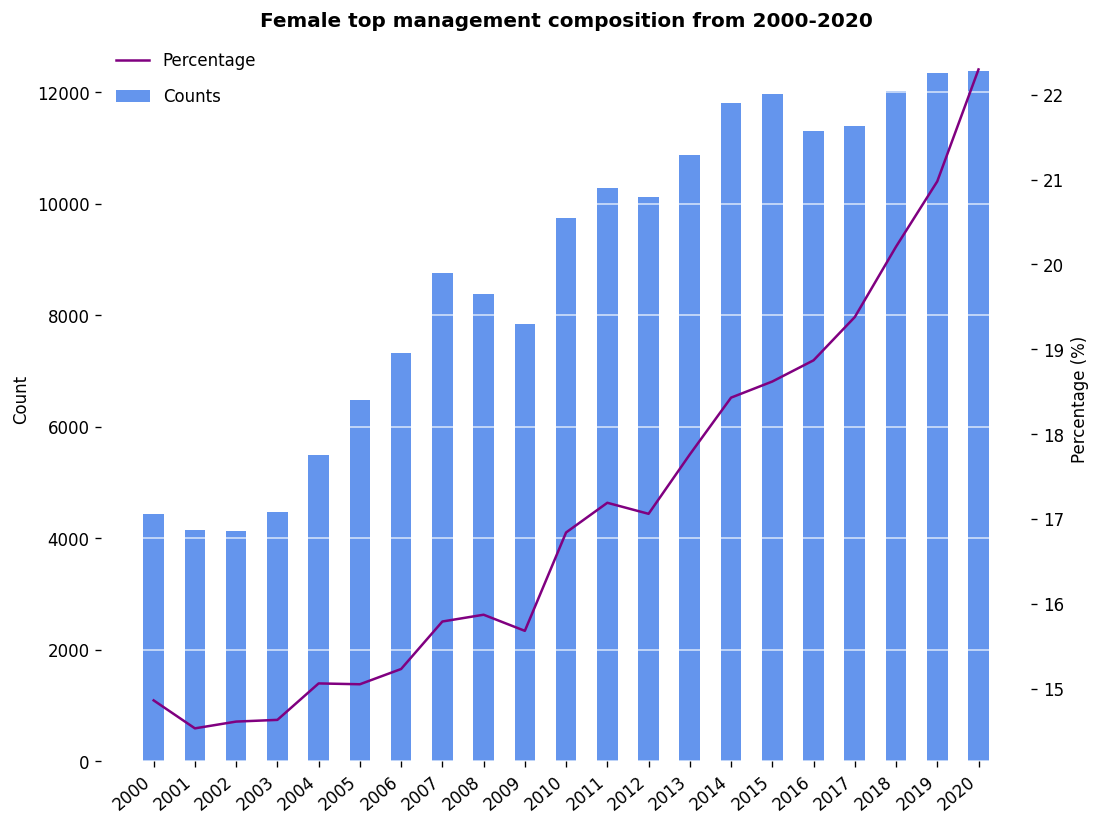

In [533]:
# Plot the change in female top managers percentage across the decades
x = gender_composition['Year'].unique()
female = gender_composition['Count'].loc[gender_composition['Gender']== 'F'] # female CEO counts
percentage = gender_composition['Percentage'].loc[gender_composition['Gender']=='F'] # percentage of female CEO

fig= plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.bar(x, female, color='cornflowerblue', width=0.5, label='Counts')

# Subplot settings
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=40, ha='right')
ax.spines[['right','bottom','top', 'left']].set_visible(False)
ax.set_title('Female top management composition from 2000-2020',fontweight='semibold' )
ax.grid(axis='y', linestyle='-', alpha=0.7, color='white', linewidth=1)
ax.set_ylabel('Count')
ax.legend(bbox_to_anchor=(0.145, 0.95), frameon=False)


ax1  = ax.twinx()
ax1.plot(x, percentage, color='purple', label='Percentage')
ax1.set_ylabel('Percentage (%)')
ax1.spines[['right','bottom','top', 'left']].set_visible(False)
ax1.legend(frameon=False)

plt.show()

### Gender by country

In [577]:
# See the gender composition of public listed companies by countries
country_gender = df.groupby('Country')['Gender'].value_counts().reset_index(name='Count')

# Get the total number of managers for each country
country_total = country_gender.groupby('Country')['Count'].sum().reset_index(name='Total Count')

# Merge the columns together
country_gender = pd.merge(country_gender, country_total, on='Country', how='left')

# Get the total percentage of managers of each gender in each country
country_gender['Percentage'] = round(country_gender['Count'] / country_gender['Total Count']*100, 2)

# Sort values by country
country_gender.sort_values(by='Total Count', ascending=False,inplace=True)
country_gender

,Country,Gender,Count,Total Count,Percentage
238,United States,F,90352,481980,18.75
237,United States,M,391628,481980,81.25
230,United Kingdom - England,F,19399,113733,17.06
229,United Kingdom - England,M,94334,113733,82.94
100,Japan,M,80289,82064,97.84
...,...,...,...,...,...
1,Anguilla,F,1,8,12.50
26,Bulgaria,F,3,7,42.86
25,Bulgaria,M,4,7,57.14
57,Falkland Islands,M,5,5,100.00


In [51]:
# Countries without female management data
no_female = country_gender['Country']
no_female.drop_duplicates(keep=False, inplace=True)
no_female

8            Azerbaijan
57     Falkland Islands
196             Somalia
Name: Country, dtype: object

In [583]:
country_gender.loc[country_gender['Gender'] == 'F'].head(50)

,Country,Gender,Count,Total Count,Percentage
238,United States,F,90352,481980,18.75
230,United Kingdom - England,F,19399,113733,17.06
101,Japan,F,1775,82064,2.16
5,Australia,F,11498,60627,18.97
30,Canada,F,9307,55814,16.68
89,India,F,3981,54525,7.30
63,France,F,8363,44629,18.74
83,Hong Kong SAR,F,6228,34465,18.07
71,Germany,F,4359,32431,13.44
36,China,F,4439,24132,18.39


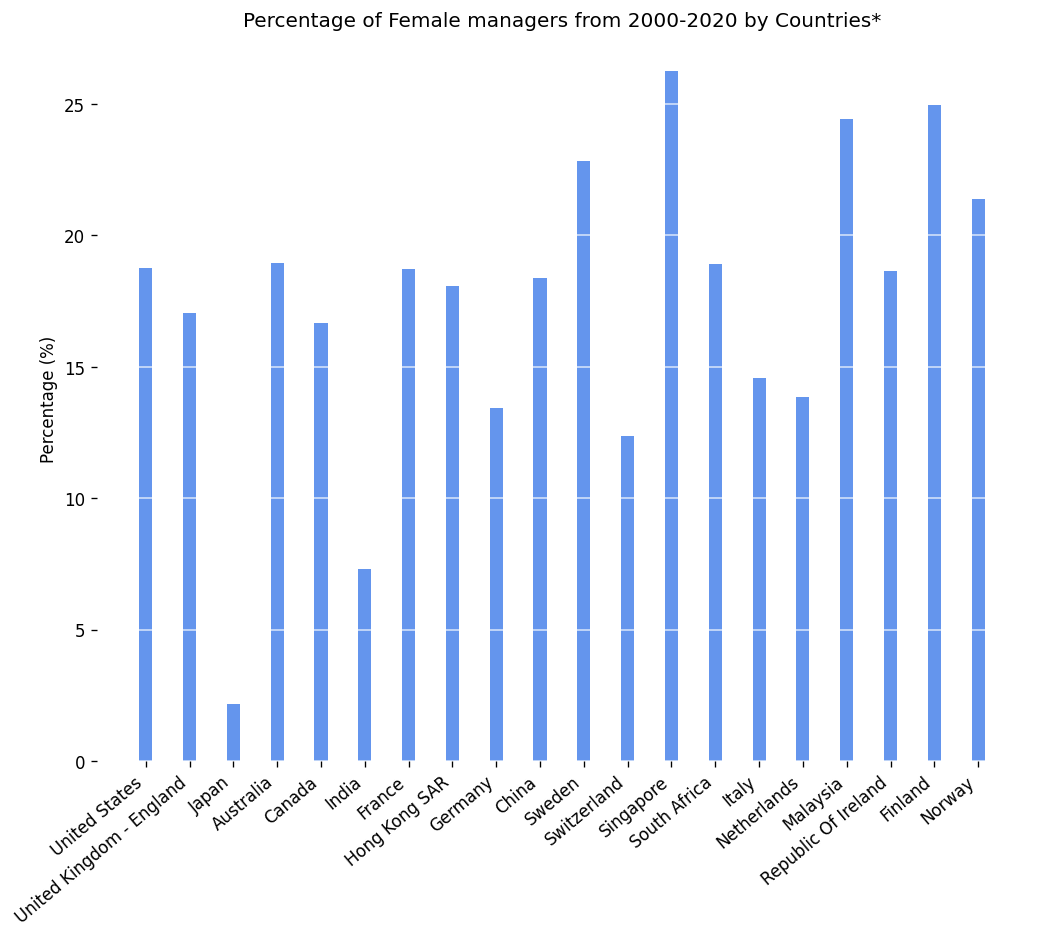

In [574]:
# Plot the percentage of female managers of top 25 countries with the most total counts
x = country_gender['Country'].head(40).unique()
y = country_gender['Percentage'].loc[country_gender['Gender'] == 'F'].head(20)

fig= plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.bar(x, y, color='cornflowerblue', width=0.3, align='center')

# # Subplot settings
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=40, ha='right')
ax.spines[['right','bottom','top', 'left']].set_visible(False)
ax.set_title('Percentage of Female managers from 2000-2020 by Countries*')
ax.grid(axis='y', linestyle='-', alpha=0.7, color='white', linewidth=1)
ax.set_ylabel('Percentage (%)')

plt.show()

* The top 25 countries with largest number of top managers in the dataset

In [565]:
# Analyse the female percentage in each country
female_percentage = country_gender.loc[country_gender['Gender'] == 'F']
female_percentage.sort_values(by='Percentage', ascending=False, inplace=True)
female_percentage.reset_index(drop=True, inplace=True)
female_percentage

,Country,Gender,Count,Total Count,Percentage
0,Jamaica,F,96,202,47.52
1,Myanmar,F,6,13,46.15
2,Georgia,F,8,18,44.44
3,Bulgaria,F,3,7,42.86
4,Ukraine,F,54,146,36.99
...,...,...,...,...,...
120,French Guiana,F,1,26,3.85
121,Saudi Arabia,F,101,2865,3.53
122,South Korea,F,142,4552,3.12
123,Gabon,F,2,84,2.38


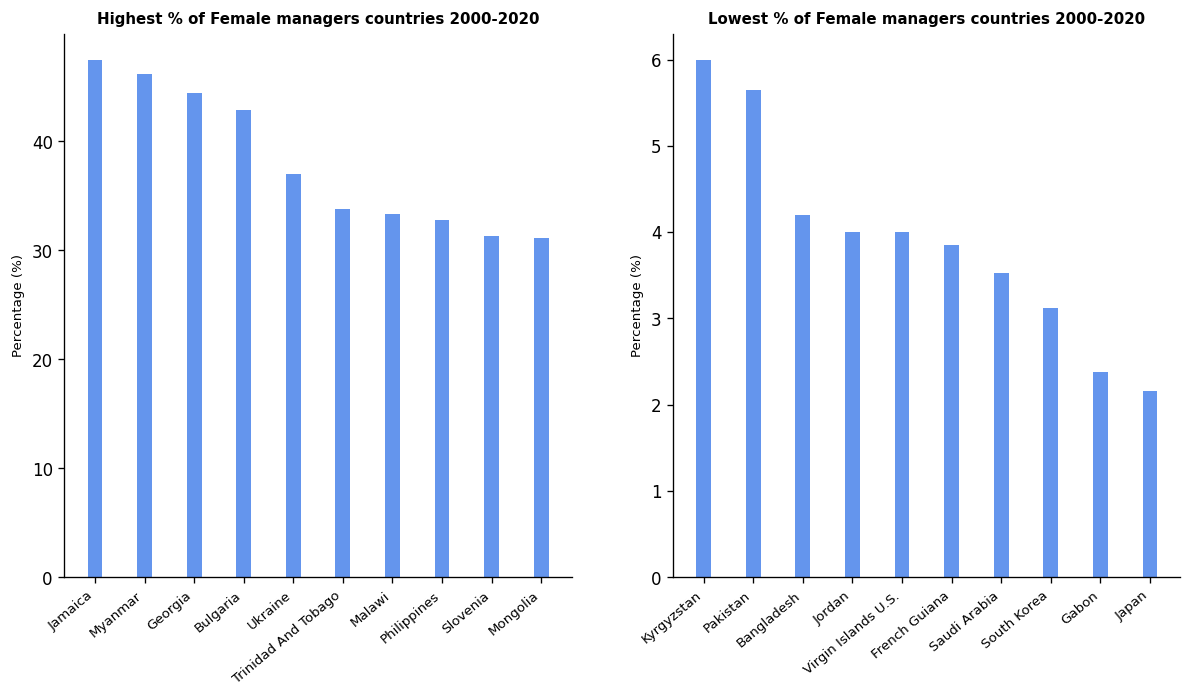

In [566]:
# Plot the top 10 countries with largest % of female managers
from matplotlib import gridspec

x_head = female_percentage['Country'].head(10)
female_head = female_percentage['Percentage'].head(10)
x_tail = female_percentage['Country'].tail(10)
female_tail = female_percentage['Percentage'].tail(10)

fig= plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
ax.bar(x_head, female_head, color='cornflowerblue', width=0.3)
ax1.bar(x_tail, female_tail, color='cornflowerblue', width=0.3)

# # Subplot settings
ax1.set_xticks(x_tail)
ax1.set_xticklabels(x_tail, rotation=40, ha='right', fontsize=8)
ax1.spines[['right','top']].set_visible(False)
ax1.set_title('Lowest % of Female managers countries 2000-2020', fontsize=9,  fontweight='semibold')
ax1.set_ylabel('Percentage (%)', fontsize=8)

# # Subplot settings
ax.set_xticks(x_head)
ax.set_xticklabels(x_head, rotation=40, ha='right', fontsize=8)
ax.spines[['right','top',]].set_visible(False)
ax.set_title('Highest % of Female managers countries 2000-2020', fontsize=9, fontweight='semibold')
# ax.grid(axis='y', linestyle='-', alpha=0.7, color='white', linewidth=1)
ax.set_ylabel('Percentage (%)', fontsize=8)

plt.show()

### Gender by sector

In [535]:
# See the gender composition of public listed companies by sector
sector_gender = df.groupby('Sector Name')['Gender'].value_counts().reset_index(name='Count')

# Get the total number of managers in each sector
sector_total = sector_gender.groupby('Sector Name')['Count'].sum().reset_index(name='Total Count')

# Merge the columns together
sector_gender = pd.merge(sector_gender, sector_total, on='Sector Name', how='left')

# Get the total percentage of managers of each gender by sector
sector_gender['Percentage'] = round(sector_gender['Count'] / sector_gender['Total Count']*100, 2)

# Sort values by sector
sector_gender.sort_values(by='Total Count', ascending=False,inplace=True)
sector_gender.reset_index(drop=True, inplace=True)
sector_gender

,Sector Name,Gender,Count,Total Count,Percentage
0,Banks,M,94252,116044,81.22
1,Banks,F,21792,116044,18.78
2,Software & Computer Services,F,16051,98084,16.36
3,Software & Computer Services,M,82033,98084,83.64
4,Pharmaceuticals and Biotechnology,F,17587,78869,22.30
...,...,...,...,...,...
87,Wholesale Trade,F,65,1651,3.94
88,Legal,F,95,250,38.00
89,Legal,M,155,250,62.00
90,Government,M,28,35,80.00


In [536]:
# Analyse the female percentage in each sector
female_percentage = sector_gender.loc[sector_gender['Gender'] == 'F']
female_percentage.sort_values(by='Percentage', ascending=False, inplace=True)
female_percentage.reset_index(drop=True, inplace=True)
female_percentage

,Sector Name,Gender,Count,Total Count,Percentage
0,Legal,F,95,250,38.00
1,Education,F,799,3083,25.92
2,Publishing,F,1343,5304,25.32
3,General Retailers,F,8435,35676,23.64
4,Clothing & Personal Products,F,4852,20865,23.25
5,Pharmaceuticals and Biotechnology,F,17587,78869,22.30
6,Real Estate,F,11033,50186,21.98
7,Media & Entertainment,F,7539,34336,21.96
8,Investment Companies,F,1902,8724,21.80
9,Consumer Services,F,797,3664,21.75


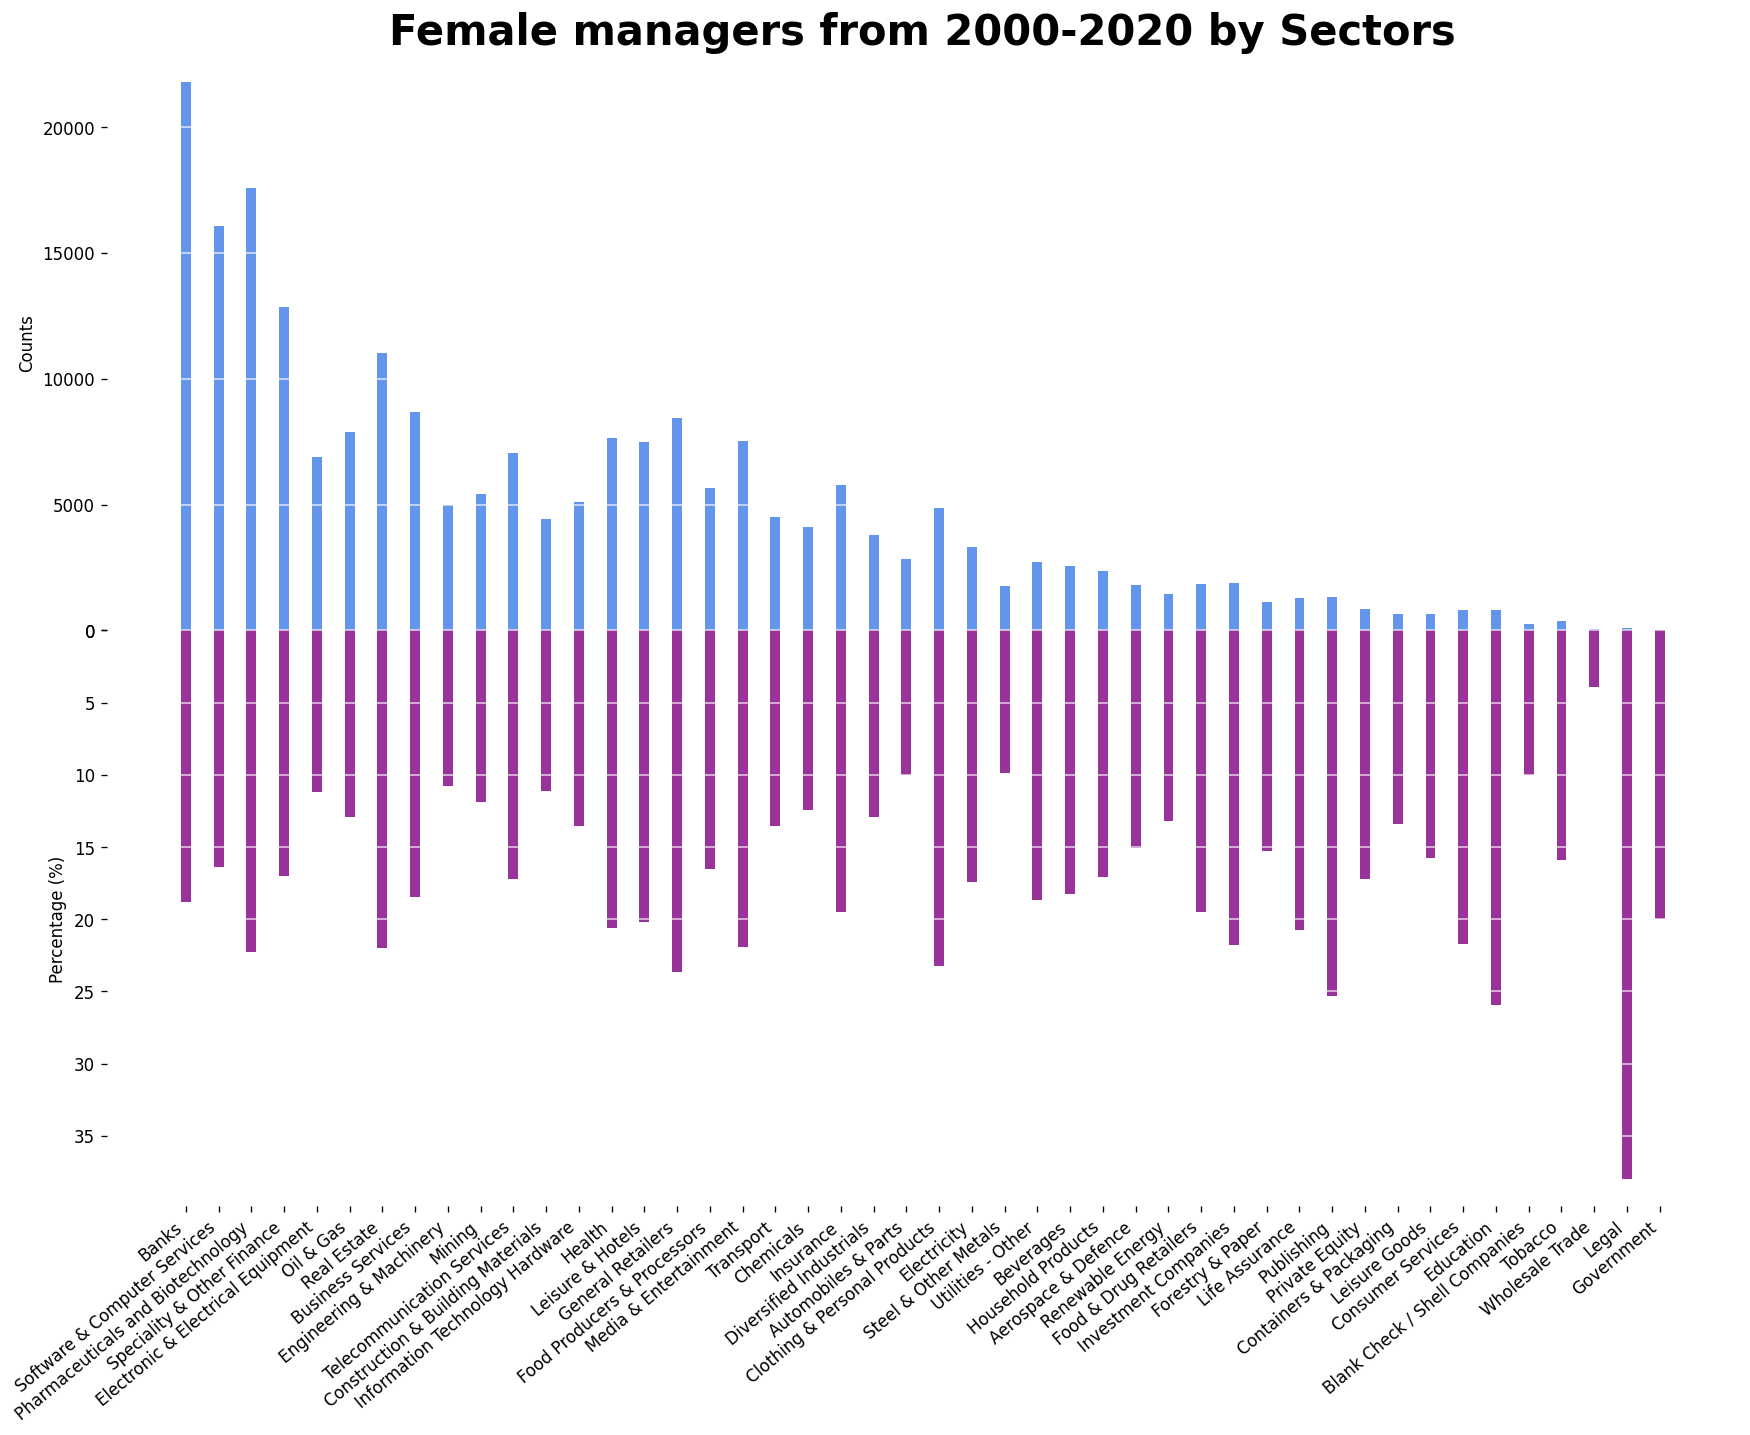

In [538]:
# Plot the % of total female managers by sector
x = sector_gender['Sector Name'].unique()
percentage = sector_gender['Percentage'].loc[sector_gender['Gender'] == 'F']
counts = sector_gender['Count'].loc[sector_gender['Gender'] == 'F']

fig= plt.figure(figsize=(17,12))
ax = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)

ax.bar(x, counts, color='cornflowerblue', width=0.3, align='center')
ax1.bar(x, -percentage, color='purple', label='Percentage', width=0.3, align='center', alpha=0.8)

# # Subplot settings
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=40, ha='right')
ax.spines[['right','bottom','top', 'left']].set_visible(False)
ax.set_title('Female managers from 2000-2020 by Sectors', fontsize=25, fontweight='semibold')
ax.grid(axis='y', linestyle='-', alpha=0.7, color='white', linewidth=1)
ax.set_ylabel('Counts')
ax.xaxis.set_visible(False)
ax1.set_ylabel('Percentage (%)')
ax1.spines[['right','bottom','top', 'left']].set_visible(False)
ax1.set_xticklabels(x, rotation=40, ha='right')
ax1.grid(axis='y', linestyle='-', alpha=0.7, color='white', linewidth=1)

# set labels to absolute values and with integer representation
ticks =  ax1.get_yticks()
ax1.set_yticklabels([int(abs(tick)) for tick in ticks])

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0)
plt.show()

## 1.3. Gender composition prediction

### ARIMA model

In [604]:
# Get the year of Start date
df['Year_Month']= df['Start Date'].dt.to_period('M')

In [605]:
# Create a new dataframe with monthly percentage of female managers
pred_df = df.groupby('Year_Month')['Gender'].value_counts().reset_index(name='Count')
# Select the observations after 2000
pred_df = pred_df.loc[pred_df['Year_Month'].dt.year >= 2000]
# Get the total monthly count of top management positions
count = pred_df.groupby('Year_Month')['Count'].sum().reset_index(name='Total Count') 
# Merge the columns together
pred_df = pd.merge(pred_df, count, on='Year_Month', how='left')
pred_df = pred_df.loc[pred_df['Gender'] == 'F']
# Get the percentage of monthly female CEOs
pred_df['Percentage'] = round(pred_df['Count'] / pred_df['Total Count']*100, 2)
pred_df= pred_df[['Year_Month','Percentage']]
pred_df.set_index('Year_Month', inplace=True)
# Convert the monthly periods as index and in string format
pred_df.index = pred_df.index.strftime('%Y-%m')
pred_df

,Percentage
Year_Month,
2000-01,16.23
2000-02,13.86
2000-03,11.21
2000-04,12.69
2000-05,13.24
...,...
2021-06,22.15
2021-07,24.15
2021-08,22.75


In [491]:
# Check if the data is stationary: p-value > 0.05 -> is not stationary
result = adfuller(pred_df['Percentage'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 2.118507
p-value: 0.998808


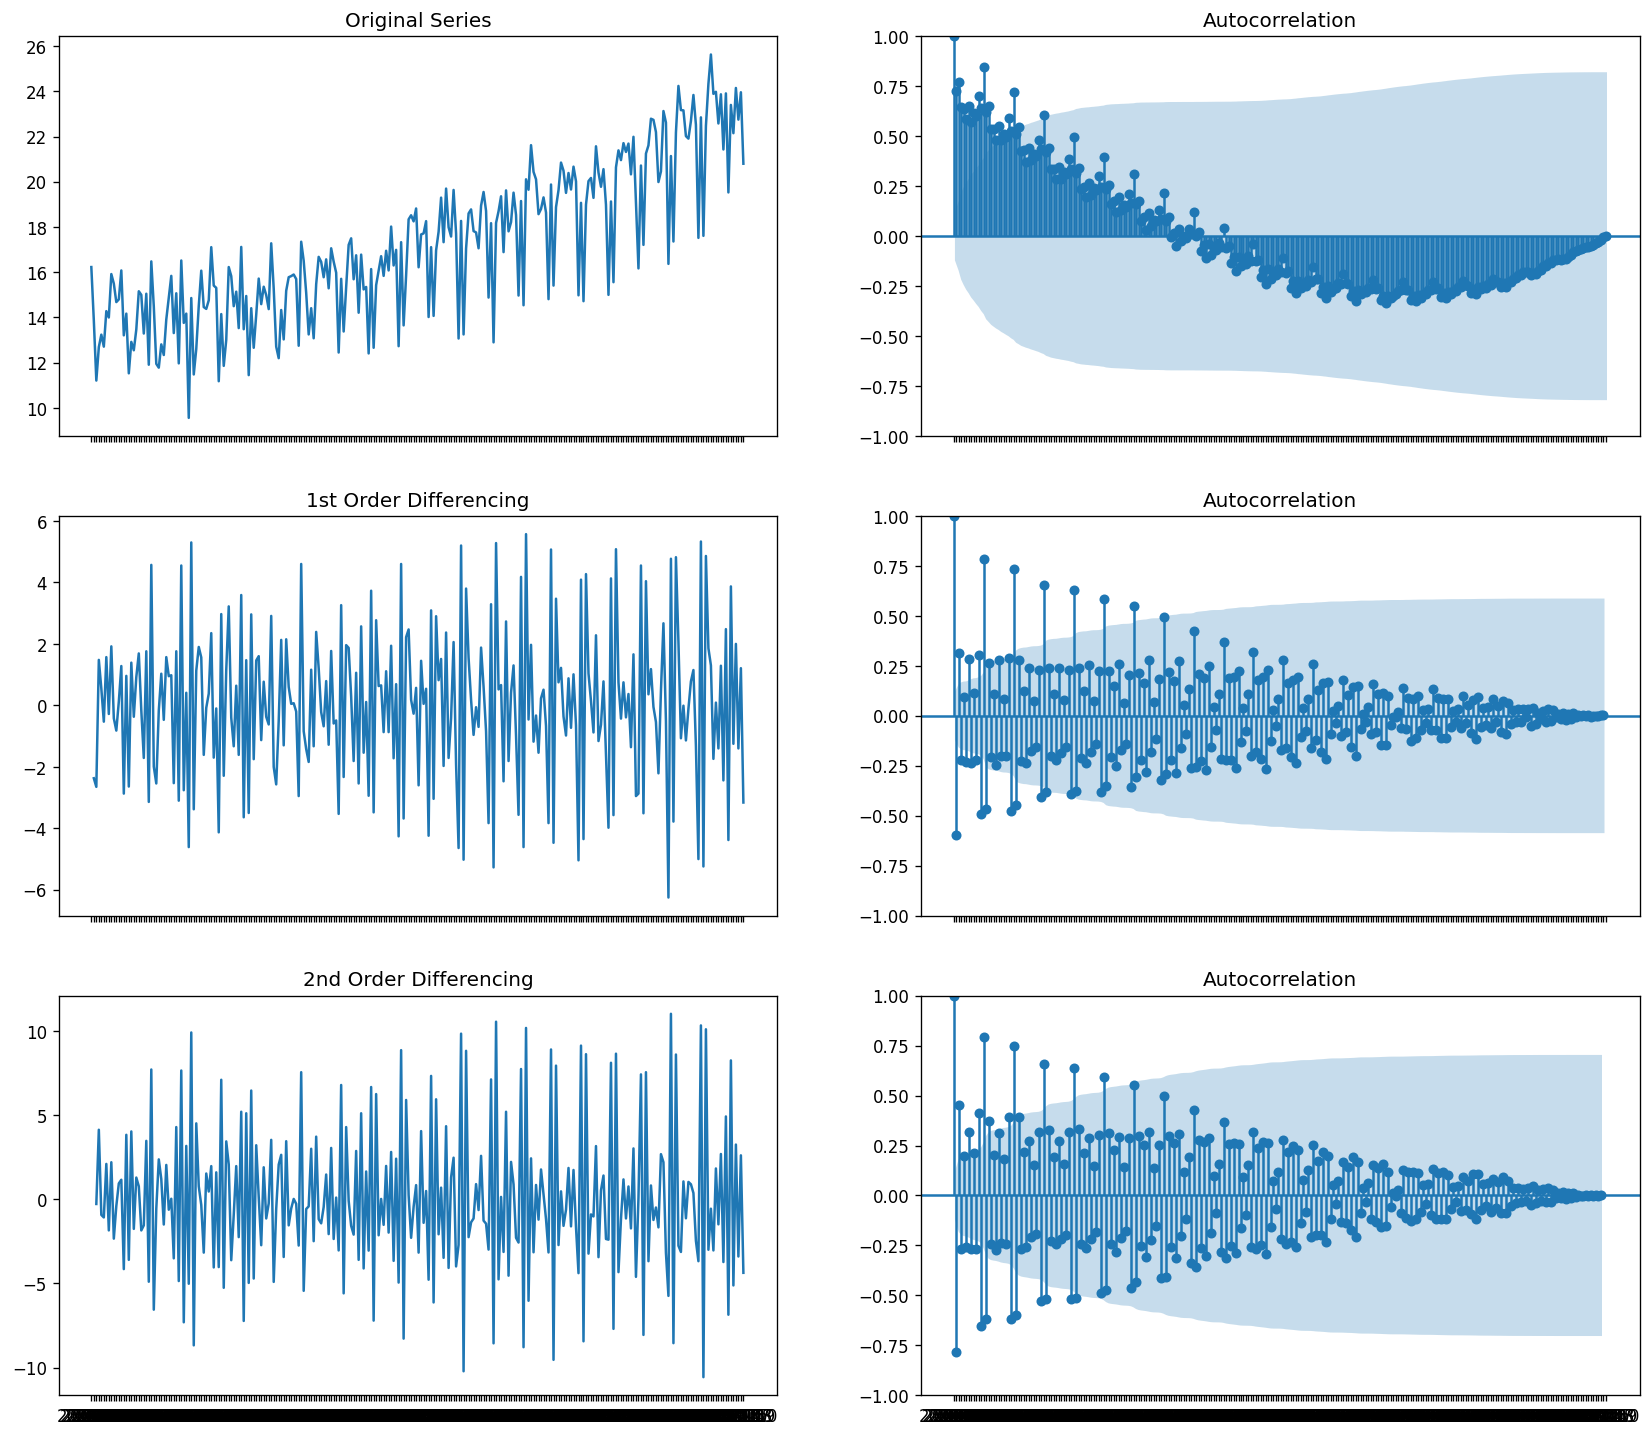

In [494]:
# Plot the autocorrelation plots to decide parameter d (differencing)
plt.rcParams.update({'figure.figsize':(17,15), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(pred_df['Percentage']); axes[0, 0].set_title('Original Series')
plot_acf(pred_df['Percentage'], ax=axes[0, 1], lags=261)

# 1st Differencing
axes[1, 0].plot(pred_df['Percentage'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(pred_df['Percentage'].diff().dropna(), ax=axes[1, 1], lags=260)

# 2nd Differencing
axes[2, 0].plot(pred_df['Percentage'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(pred_df['Percentage'].diff().diff().dropna(), ax=axes[2, 1], lags=259)


plt.show()

In [496]:
# Check the differencing required 
result = adfuller(pred_df['Percentage'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('1st p-value: %f' % result[1])

result = adfuller(pred_df['Percentage'].diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('2nd p-value: %f' % result[1])

ADF Statistic: -23.341280
1st p-value: 0.000000
ADF Statistic: -9.297419
2nd p-value: 0.000000


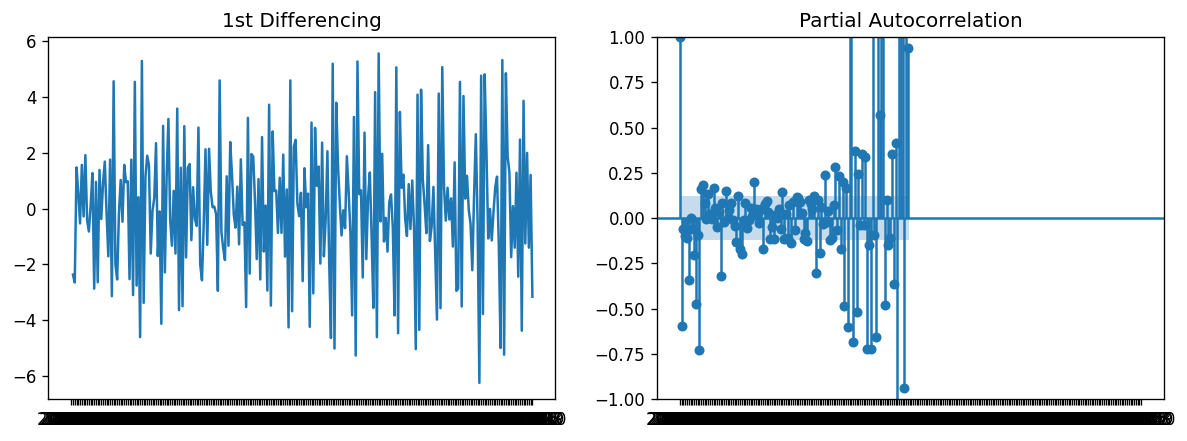

In [499]:
# PACF plot of 1st differenced series, to determine the p order
plt.rcParams.update({'figure.figsize':(12,4), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(pred_df['Percentage'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(pred_df['Percentage'].diff().dropna(), ax=axes[1], lags=129)

plt.show()

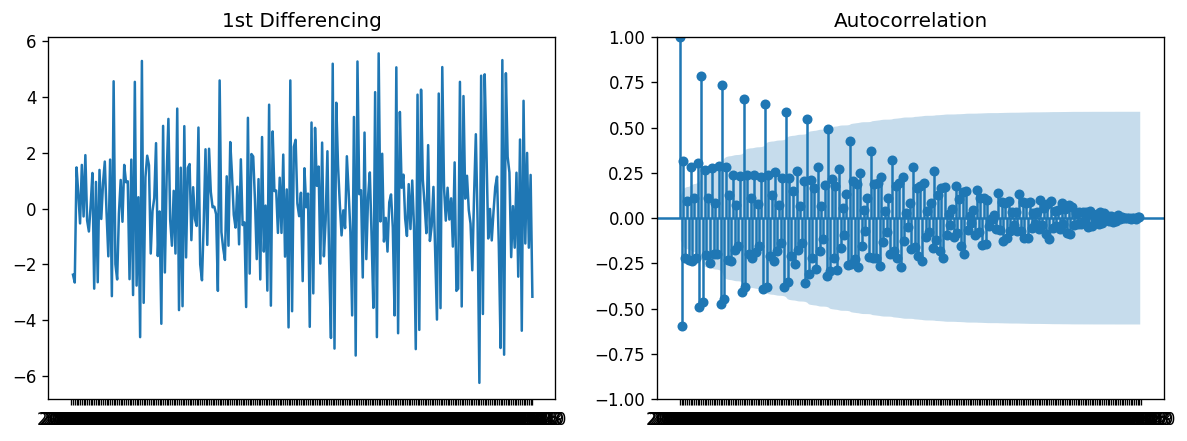

In [500]:
# To deterime the q order of the model
plt.rcParams.update({'figure.figsize':(12,4), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(pred_df['Percentage'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(pred_df['Percentage'].diff().dropna(), ax=axes[1], lags=260)

plt.show()

In [606]:
# Fit the ARIMA model (11,2,1) on train and predict on test
X = pred_df.values
train, test = X[0:252], X[252:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
	model = ARIMA(history, order=(11,2,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=23.438682, expected=23.870000
predicted=24.263683, expected=21.430000
predicted=23.196941, expected=23.910000
predicted=18.762977, expected=19.530000
predicted=23.224446, expected=23.400000
predicted=19.247196, expected=22.150000
predicted=23.655087, expected=24.150000
predicted=25.100788, expected=22.750000
predicted=25.984824, expected=23.960000
predicted=24.081264, expected=20.800000


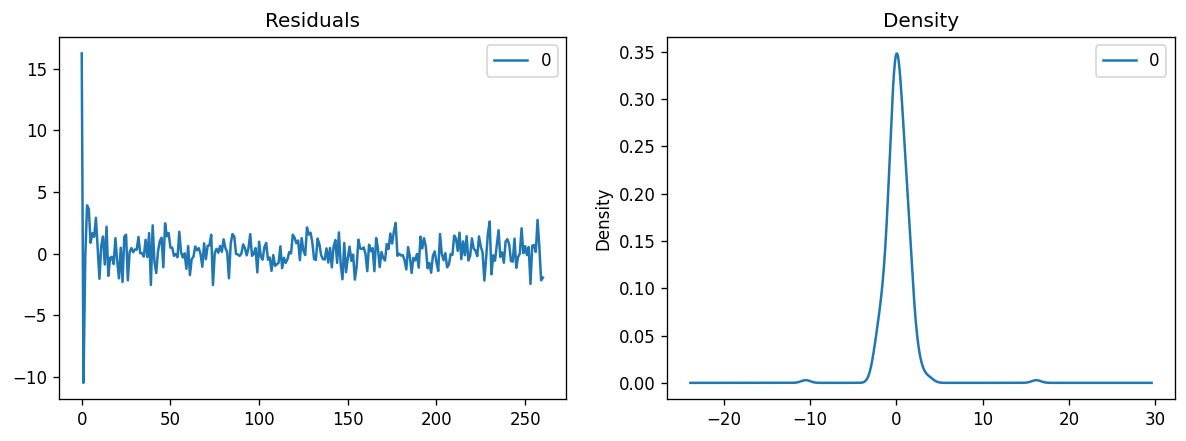

In [511]:
# Plot residual errors of the model
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [594]:
# evaluate the model
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
mape = np.mean(np.abs(predictions - test)/np.abs(test))
print('Test MAPE: %.3f' % mape)

Test RMSE: 1.960
Test MAPE: 0.097


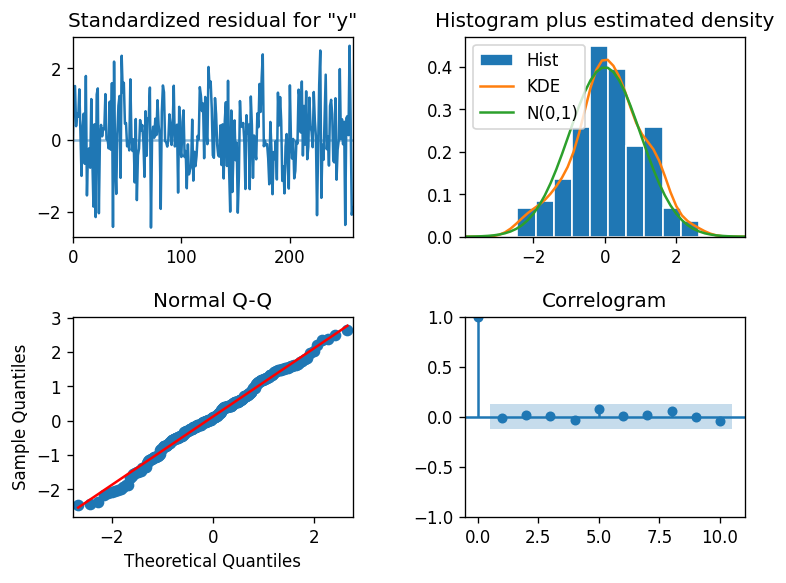

In [505]:
# Residual plots of the model
model_fit.plot_diagnostics(figsize=(7,5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

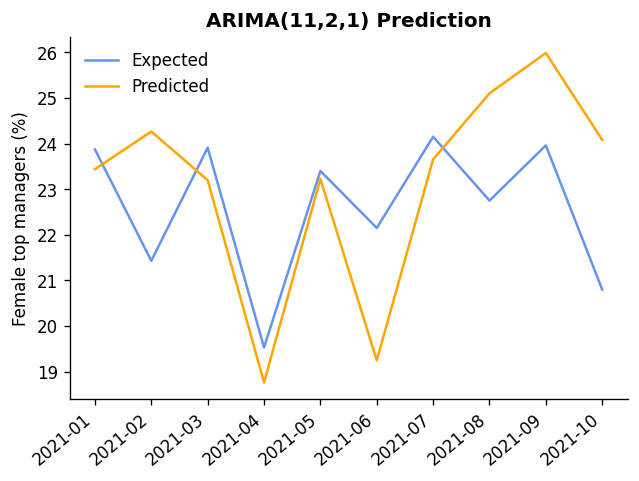

In [607]:
# Plot the actual against the predicted values
x_label = pred_df.index[252: len(X)]
fig= plt.figure(figsize=(6,4))
ax = fig.add_subplot()
ax.plot(x_label, test, color='cornflowerblue', label= 'Expected')
ax.plot(x_label, predictions, color='orange', label='Predicted')
ax.set_xticklabels(x_label, rotation=40, ha='right')
ax.set_title('ARIMA(11,2,1) Prediction', fontweight='semibold')
ax.spines[['top','right']].set_visible(False)
ax.legend(frameon=False)
ax.set_ylabel('Female top managers (%)')

plt.show()

### Predicting 2021-2022

In [609]:
# Using all the observations to predict the next 12 months
model = ARIMA(pred_df, order=(11,2,1))
model_fit = model.fit()
pred_perc= model_fit.predict(start=262, end=275)
pred_perc

2021-11-01    24.332125
2021-12-01    22.872971
2022-01-01    24.438229
2022-02-01    22.190198
2022-03-01    24.287796
2022-04-01    20.643710
2022-05-01    24.000538
2022-06-01    22.716617
2022-07-01    24.572607
2022-08-01    23.222810
2022-09-01    24.588737
2022-10-01    21.813970
2022-11-01    24.779150
2022-12-01    23.299381
Freq: MS, Name: predicted_mean, dtype: float64

In [610]:
# Add the predicted percentage to the dataframe
pred_time = ['2021-11', '2021-12', '2022-01', '2022-02',
               '2022-03', '2022-04', '2022-05', '2022-06',
               '2022-07', '2022-08', '2022-09', '2022-10',
               '2022-11', '2022-12']
pred_perc= list(pred_perc)
prediction = {'Year_Month': pred_time, 'Percentage': pred_perc}
prediction = pd.DataFrame(prediction)
prediction.set_index('Year_Month', inplace=True)
pred_df = pred_df.append(prediction)
pred_df

,Percentage
Year_Month,
2000-01,16.230000
2000-02,13.860000
2000-03,11.210000
2000-04,12.690000
2000-05,13.240000
...,...
2022-08,23.222810
2022-09,24.588737
2022-10,21.813970


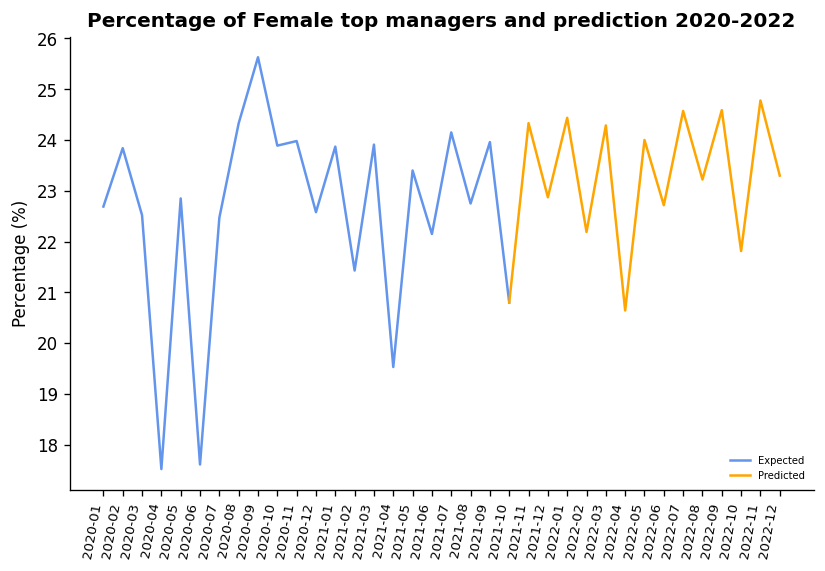

In [646]:
# Plot the actual against the predicted values
x_label = pred_df.index[240: 262]
x_label2 = pred_df.index[261:276]
perc1 = pred_df['Percentage'].iloc[240: 262]
perc2 = pred_df['Percentage'].iloc[261: 276]

fig= plt.figure(figsize=(8,5))
ax = fig.add_subplot()
ax.plot(x_label, perc1, color='cornflowerblue', label= 'Expected')
ax.plot(x_label2, perc2, color='orange', label='Predicted')
ax.set_xticks(pred_df.index[240:len(pred_df)])
ax.set_xticklabels(pred_df.index[240:len(pred_df)], rotation=80, ha='right', fontsize=8)
ax.set_title('Percentage of Female top managers and prediction 2020-2022', fontweight='semibold')
ax.spines[['top','right']].set_visible(False)
ax.legend(frameon=False, fontsize=6, loc='lower right')
ax.set_ylabel('Percentage (%)')

plt.show()

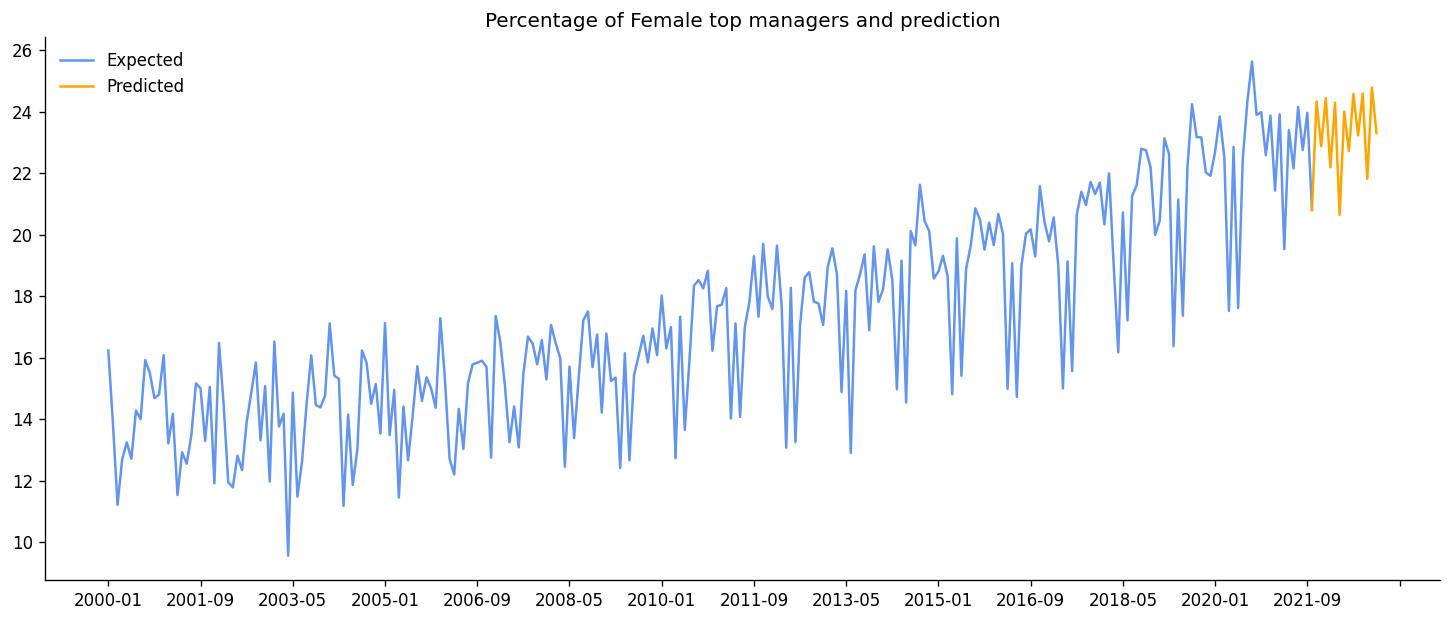

In [625]:
# Plot the predicted values with the original observations
time = pred_df.index.to_series().astype(str)
x_label1 = time[0:262]
x_label2 = time[261:276]
perc1 = pred_df['Percentage'].iloc[0: 262]
perc2 = pred_df['Percentage'].iloc[261: 276]

fig= plt.figure(figsize=(15,6))
ax = fig.add_subplot()
ax.plot(x_label1,perc1 , color='cornflowerblue', label= 'Expected')
ax.plot(x_label2, perc2, color='orange', label='Predicted')
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.spines[['right','top']].set_visible(False)
ax.set_title('Percentage of Female top managers and prediction')
ax.legend(loc='upper left', frameon=False)

plt.show()

# Research Question 2: CEO vacancy Dataframe

## Role Dataframe

### Cleaning and Preprocessing

In [197]:
# Create a new dataframe from the df
role = df[['DirectorID*', 'Director Name_x','CompanyID*', 'Company Name','Sector Name' ,'Role','Start Date', 'End Date','Gender']]

# Remove duplicates
role.drop_duplicates(inplace=True)

# Sort the dataframe by Start Date and DirectorID*
role.sort_values(by=['DirectorID*', 'Start Date'], inplace=True)

# Convert Start date and End date to datetime
role['Start Date'] = pd.to_datetime(role['Start Date'])
role['End Date'] = pd.to_datetime(role['End Date'])
role

,DirectorID*,Director Name_x,CompanyID*,Company Name,Sector Name,Role,Start Date,End Date,Gender
825915,1680,David John Blakeman,2607112325,LOOKERS PLC,Automobiles & Parts,Various Positions,1984-01-01,1989-01-01,M
800883,1680,David John Blakeman,2607112325,LOOKERS PLC,Automobiles & Parts,ED/Secretary,1989-01-01,2007-01-02,M
821496,2440,Andrew David McClure,3668011673,SMART(J.)& CO(CONTRACTORS) PLC,Real Estate,Various Positions,1964-01-01,1985-01-01,M
821495,2440,Andrew David McClure,3668011673,SMART(J.)& CO(CONTRACTORS) PLC,Real Estate,Company Secretary,1985-01-01,1987-01-01,M
797752,2440,Andrew David McClure,3668011673,SMART(J.)& CO(CONTRACTORS) PLC,Real Estate,FD/Secretary,1987-01-01,2011-11-18,M
...,...,...,...,...,...,...,...,...,...
1128185,207076712928,Kenneth (Ken) Feather,175498510596,ARCHER LTD (Seawell Ltd prior to 05/2011),Oil & Gas,Various Positions,2010-10-01,2013-12-01,M
1128187,207076712928,Kenneth (Ken) Feather,175498510596,ARCHER LTD (Seawell Ltd prior to 05/2011),Oil & Gas,Division VP,2013-12-01,2015-11-01,M
1128186,207076712928,Kenneth (Ken) Feather,175498510596,ARCHER LTD (Seawell Ltd prior to 05/2011),Oil & Gas,Division VP - Sales/Marketing,2015-12-01,2016-08-01,M
775719,207076912928,Olivier Bojarski,91518506,BELDEN INC (Belden CDT Inc prior to 05/2007),Electronic & Electrical Equipment,Executive VP,2021-05-01,2021-11-01,M


In [198]:
# Merge the education dataframe with role dataframe
role = pd.merge(role, Education, on='DirectorID*', how='left')

In [199]:
# Drop the observations with Bachelor, Master, Doctorate, MBA, and Other as NaN
role.dropna(subset=['Bachelor', 'Master', 'Doctorate', 'MBA', 'Other'], inplace=True)

# Reset the index of the dataframe
role=role.reset_index(drop=True)

# Create new columns: Next Role, Experience, Source Company and Source company sector
role ['Previous Role'] = ''
role['Source company'] = ''
role['Source company sector'] = ''
role['Experience'] = date.today() - date.today()
role

,DirectorID*,Director Name_x,CompanyID*,Company Name,Sector Name,Role,Start Date,End Date,Gender,Bachelor,Doctorate,MBA,Master,Other,Previous Role,Source company,Source company sector,Experience
0,1680,David John Blakeman,2607112325,LOOKERS PLC,Automobiles & Parts,Various Positions,1984-01-01,1989-01-01,M,1.0,0.0,0.0,0.0,0.0,,,,0 days
1,1680,David John Blakeman,2607112325,LOOKERS PLC,Automobiles & Parts,ED/Secretary,1989-01-01,2007-01-02,M,1.0,0.0,0.0,0.0,0.0,,,,0 days
2,3040,Harold (Harry) William Bailey,547611620,ASSOCIATED BRITISH FOODS PLC,Food Producers & Processors,ED,1979-01-01,1996-04-01,M,0.0,0.0,0.0,0.0,1.0,,,,0 days
3,3040,Harold (Harry) William Bailey,547611620,ASSOCIATED BRITISH FOODS PLC,Food Producers & Processors,Deputy Chairman,1996-04-01,2000-05-31,M,0.0,0.0,0.0,0.0,1.0,,,,0 days
4,3040,Harold (Harry) William Bailey,547611620,ASSOCIATED BRITISH FOODS PLC,Food Producers & Processors,Chairman (Executive),2000-05-31,2002-12-05,M,0.0,0.0,0.0,0.0,1.0,,,,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052183,207076712928,Kenneth (Ken) Feather,175498510596,ARCHER LTD (Seawell Ltd prior to 05/2011),Oil & Gas,Division VP - Sales/Marketing,2009-03-01,2010-10-01,M,1.0,0.0,0.0,0.0,1.0,,,,0 days
1052184,207076712928,Kenneth (Ken) Feather,175498510596,ARCHER LTD (Seawell Ltd prior to 05/2011),Oil & Gas,Various Positions,2010-10-01,2013-12-01,M,1.0,0.0,0.0,0.0,1.0,,,,0 days
1052185,207076712928,Kenneth (Ken) Feather,175498510596,ARCHER LTD (Seawell Ltd prior to 05/2011),Oil & Gas,Division VP,2013-12-01,2015-11-01,M,1.0,0.0,0.0,0.0,1.0,,,,0 days
1052186,207076712928,Kenneth (Ken) Feather,175498510596,ARCHER LTD (Seawell Ltd prior to 05/2011),Oil & Gas,Division VP - Sales/Marketing,2015-12-01,2016-08-01,M,1.0,0.0,0.0,0.0,1.0,,,,0 days


In [200]:
# For loop to fill the new columns created above
for index, row in role.iterrows():
    if index < len(role)-1:
        # If the next directorID is the same
        if role.iloc[index,0] == role.iloc[index+1,0]:
            # The previous role is the same as the previous row of role
            role.iloc[index+1, 14] = role.iloc[index, 5]
            # The source company is the same as the previous row
            role.iloc[index+1, 15] = role.iloc[index, 3]
            # The source company sector is the same as the previous row
            role.iloc[index+1, 16] = role.iloc[index, 4]
            # Accumulative experience (sum the previous experience with the current one)
            role.iloc[index+1, 17] = role.iloc[index+1,6] - role.iloc[index,6] + role.iloc[index,17]
        else:
            pass
    else:
        pass

In [223]:
# Drop unnecessary columns
role.drop(columns=['Company Name','Sector Name'], inplace=True)
role

,DirectorID*,Director Name_x,CompanyID*,Role,Start Date,End Date,Gender,Bachelor,Doctorate,MBA,Master,Other,Previous Role,Source company,Source company sector,Experience
0,1680,David John Blakeman,2607112325,Various Positions,1984-01-01,1989-01-01,M,1.0,0.0,0.0,0.0,0.0,,,,0 days
1,1680,David John Blakeman,2607112325,ED/Secretary,1989-01-01,2007-01-02,M,1.0,0.0,0.0,0.0,0.0,Various Positions,LOOKERS PLC,Automobiles & Parts,1827 days
2,3040,Harold (Harry) William Bailey,547611620,ED,1979-01-01,1996-04-01,M,0.0,0.0,0.0,0.0,1.0,,,,0 days
3,3040,Harold (Harry) William Bailey,547611620,Deputy Chairman,1996-04-01,2000-05-31,M,0.0,0.0,0.0,0.0,1.0,ED,ASSOCIATED BRITISH FOODS PLC,Food Producers & Processors,6300 days
4,3040,Harold (Harry) William Bailey,547611620,Chairman (Executive),2000-05-31,2002-12-05,M,0.0,0.0,0.0,0.0,1.0,Deputy Chairman,ASSOCIATED BRITISH FOODS PLC,Food Producers & Processors,7821 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052183,207076712928,Kenneth (Ken) Feather,175498510596,Division VP - Sales/Marketing,2009-03-01,2010-10-01,M,1.0,0.0,0.0,0.0,1.0,Regional Marketing Manager,SCHLUMBERGER LIMITED,Oil & Gas,6999 days
1052184,207076712928,Kenneth (Ken) Feather,175498510596,Various Positions,2010-10-01,2013-12-01,M,1.0,0.0,0.0,0.0,1.0,Division VP - Sales/Marketing,ARCHER LTD (Seawell Ltd prior to 05/2011),Oil & Gas,7578 days
1052185,207076712928,Kenneth (Ken) Feather,175498510596,Division VP,2013-12-01,2015-11-01,M,1.0,0.0,0.0,0.0,1.0,Various Positions,ARCHER LTD (Seawell Ltd prior to 05/2011),Oil & Gas,8735 days
1052186,207076712928,Kenneth (Ken) Feather,175498510596,Division VP - Sales/Marketing,2015-12-01,2016-08-01,M,1.0,0.0,0.0,0.0,1.0,Division VP,ARCHER LTD (Seawell Ltd prior to 05/2011),Oil & Gas,9465 days


In [224]:
# Save role dataframe to csv
#role.to_csv('Role.csv', index=False)

## Vacancy Dataframe

### Cleaning and Preprocessing

In [541]:
# df = pd.read_csv('Clean_df.csv')
# role = pd.read_csv('Role.csv')

In [542]:
df

,Country,DirectorID*,Director Name_x,CompanyID*,Company Name,Company Ticker,Company Index,Sector Name,Role,ED/NED/SM,Start Date,End Date,Gender,Nationality
0,Austria,51690811635,A (Aris) G Bogdaneris,8489622427,RAIFFEISEN BANK INTERNATIONAL AG (Raiffeisen I...,RBI,Yes,Banks,Board Member - ED,ED,2004-10-01,2010-12-01,M,Canadian
1,Austria,51690811635,A (Aris) G Bogdaneris,8489622427,RAIFFEISEN BANK INTERNATIONAL AG (Raiffeisen I...,RBI,Yes,Banks,COO,ED,2010-12-01,2015-03-31,M,Canadian
2,Netherlands,6603475665,A (Jos) Andeweg,407445259,UNIT4 NV (Unit 4 Agresso NV prior to 06/2010) ...,UNIT4,No,Software & Computer Services,Board Member - ED,ED,2007-01-01,2014-01-01,M,Dutch
3,Netherlands,16531779758,A (Tineke) J Veldhuis-Hagedoorn,210628883,HOLLAND COLOURS NV,HOLCO,No,Chemicals,Regional MD,ED,1979-01-01,2016-01-01,F,Dutch
4,Netherlands,6446592907,A (Ton) G Hillen,206138525,HEIJMANS NV,HEIJM,No,Construction & Building Materials,Board Member - ED,ED,2012-04-18,2016-12-01,M,Dutch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319350,Israel,23236976192,Zvika (Zvi) Fishheimer,3823112661,SHUFERSAL LTD,SAE,No,Food & Drug Retailers,Executive VP - HR/Admin,SM,2015-02-10,2021-11-01,M,Unknown
1319351,Israel,13122316295,Zvika (Zvi) Shwimmer,2734288787,ELCO LTD (Elco Holdings Ltd prior to 02/2014),ELCO,No,Engineering & Machinery,Division CEO,SM,2018-10-02,2021-11-01,M,Unknown
1319352,South Africa,8775087049,Zweli Manyathi,8305712816,STANDARD BANK GROUP LTD,SBK,No,Banks,Division CEO,SM,2021-01-01,2021-11-01,M,Unknown
1319353,South Africa,24711437875,Zweli Ndese,203388297,HARMONY GOLD MINING CO LTD,HAR,No,Mining,Regional General Manager,SM,2020-10-01,2021-11-01,M,Unknown


In [543]:
# Select the columns with the needed information regarding each vacancy and company level
vacancy = df[['Start Date','Role','CompanyID*', 'Company Name','Company Index','Country','Sector Name', 'End Date']]

# Convert the timestamp column to a datetime
vacancy['Start Date'] = pd.to_datetime(vacancy['Start Date'])
vacancy['End Date'] = pd.to_datetime(vacancy['End Date'])


# Select the observations with End Date after 2000-01-01
vacancy = vacancy[vacancy['Start Date'] >= '2000-01-01']

# Remove duplicates
vacancy.drop_duplicates(subset=['Start Date', 'CompanyID*', 'Role'], inplace=True)

# Sort the dataframe by the End Date
vacancy.sort_values(by=['Start Date'], inplace=True)

# Reset the index
vacancy.reset_index(drop=True, inplace=True)
vacancy

,Start Date,Role,CompanyID*,Company Name,Company Index,Country,Sector Name,End Date
0,2000-01-01,Senior VP/General Counsel/Corporate Secretary,390672235,TELLABS INC (De-listed 12/2013),No,United States,Electronic & Electrical Equipment,2002-01-01
1,2000-01-01,Controller,290285029,NATUS MEDICAL INC,Yes,United States,Electronic & Electrical Equipment,2003-01-01
2,2000-01-01,COO,78829108,BANK OF MONTREAL (BMO) (BMO Financial Group),Yes,Canada,Banks,2006-11-01
3,2000-01-01,General Manager,389601912,TELECOMPUTING ASA (De-listed 02/2010),No,Norway,Software & Computer Services,2005-05-01
4,2000-01-01,Regional Director - Sales/Marketing,3766612310,STARWOOD HOTELS & RESORTS WORLDWIDE INC (De-li...,No,United States,Leisure & Hotels,2003-05-01
...,...,...,...,...,...,...,...,...
1031866,2021-10-05,Corporate Secretary,22027924416,VASCULAR BIOGENICS LTD (VBL Therapeutics),No,Israel,Pharmaceuticals and Biotechnology,2021-11-01
1031867,2021-10-05,Company Secretary,24503787662,OVER THE WIRE HOLDINGS LTD,Yes,Australia,Telecommunication Services,2021-11-01
1031868,2021-10-05,Chief Commercial Officer,21453223298,QUOTIENT LTD,No,Switzerland,Health,2021-11-01
1031869,2021-10-05,Exploration Manager,177058510726,AEON METALS LTD (Aussie Q Resources Ltd prior ...,No,Australia,Mining,2021-11-01


In [207]:
vacancy['Role'].value_counts()

Various Positions                                    49826
CFO                                                  24139
CEO                                                  20751
President/CEO                                        16665
Vice President                                       15584
                                                     ...  
Chief Asset & Wealth Management Officer                  1
Executive VP/Chief Continuous Improvement Officer        1
Director - Corporate Planning/HR/Investment              1
Head of Consumer Strategy                                1
Chief Commercial Regulation & Development Officer        1
Name: Role, Length: 26138, dtype: int64

## 2.1. CEO_vacancy dataframe

### Cleaning and Preprocessing

In [544]:
# Select just the rows with Role= CEO
CEO_vacancy = vacancy.loc[(vacancy['Role'] == 'CEO') | (vacancy['Role'].str.contains('CEO/|/CEO'))]

# Remove the observations that contains the word 'Division' and 'Regional'
CEO_vacancy = CEO_vacancy[~CEO_vacancy['Role'].str.contains('Division|Regional')]

# Replace the Role values to CEO 
CEO_vacancy['Vacancy'] = 'CEO'

# Convert End Date to datetime
CEO_vacancy['End Date'] = pd.to_datetime(CEO_vacancy['End Date'])  
CEO_vacancy['Start Date'] = pd.to_datetime(CEO_vacancy['Start Date'])  

# Remove duplicates
CEO_vacancy.drop_duplicates(subset=['Start Date', 'CompanyID*', 'Role'],inplace=True)

# Sort values
CEO_vacancy.sort_values(by=['CompanyID*', 'Start Date'], inplace=True)

# Reset the index
CEO_vacancy.reset_index(drop=True, inplace=True)
CEO_vacancy


,Start Date,Role,CompanyID*,Company Name,Company Index,Country,Sector Name,End Date,Vacancy
0,2000-02-01,CEO,1170,CENTRAL WEALTH GROUP HOLDINGS LTD (China Soft ...,No,Hong Kong SAR,Diversified Industrials,2014-04-01,CEO
1,2014-04-01,Chairman/CEO,1170,CENTRAL WEALTH GROUP HOLDINGS LTD (China Soft ...,No,Hong Kong SAR,Diversified Industrials,2015-02-26,CEO
2,2015-02-27,CEO/MD,1170,CENTRAL WEALTH GROUP HOLDINGS LTD (China Soft ...,No,Hong Kong SAR,Diversified Industrials,2015-04-20,CEO
3,2018-02-27,CEO,1170,CENTRAL WEALTH GROUP HOLDINGS LTD (China Soft ...,No,Hong Kong SAR,Diversified Industrials,2021-11-01,CEO
4,2016-06-30,President/CEO,1290,1-800-FLOWERS.COM INC,No,United States,General Retailers,2021-11-01,CEO
...,...,...,...,...,...,...,...,...,...
59024,2019-02-19,President/CEO/Chief Science Officer,308410012914,SOLITON INC,No,United States,Health,2020-11-02,CEO
59025,2020-11-02,President/CEO,308410012914,SOLITON INC,No,United States,Health,2021-11-01,CEO
59026,2013-07-16,President/CEO,308476712921,GIKEN LTD,No,Japan,Engineering & Machinery,2020-11-25,CEO
59027,2019-02-15,Chairman/CEO,308637212928,OUTBACK GOLDFIELDS CORP (Skarb Exploration Cor...,No,Canada,Mining,2020-10-01,CEO


### Feature Engineering

In [545]:
# Select the columns that is needed
gender = df[['DirectorID*', 'CompanyID*', 'Role', 'Gender', 'Start Date', 'End Date']]

# Select the observations with vacancy CEO
gender = gender.loc[(gender['Role']== 'CEO') | (gender['Role'].str.contains('CEO/|/CEO'))]
# Remove the observations that contains the word 'Division' and 'Regional'
gender = gender[~gender['Role'].str.contains('Division|Regional')]

# Convert the End Date and Start Date to datetime
gender['End Date'] = pd.to_datetime(gender['End Date'])
gender['Start Date'] = pd.to_datetime(gender['Start Date'])

# Sort the gender dataframe by companyID* and the start date
gender.sort_values(by=['CompanyID*', 'Start Date'], inplace=True)

# Remove duplicates
gender.drop_duplicates(subset=['DirectorID*', 'CompanyID*', 'Start Date'],inplace=True)

# Reset the index
gender.reset_index(drop=True, inplace=True)

# Create an empty column called ex-ceo gender
gender['Ex-ceo Gender']= ''
gender

,DirectorID*,CompanyID*,Role,Gender,Start Date,End Date,Ex-ceo Gender
0,177365010751,1170,CEO,M,2000-02-01,2014-04-01,
1,177365010751,1170,Chairman/CEO,M,2014-04-01,2015-02-26,
2,15856529154,1170,CEO/MD,M,2015-02-27,2015-04-20,
3,206011412858,1170,CEO,M,2018-02-27,2021-11-01,
4,10167110612,1290,Chairman/CEO,M,1976-04-01,1986-01-01,
...,...,...,...,...,...,...,...
69578,15539048864,308410012914,President/CEO/Chief Science Officer,M,2019-02-19,2020-11-02,
69579,173044710398,308410012914,President/CEO,M,2020-11-02,2021-11-01,
69580,23968127072,308476712921,President/CEO,M,2013-07-16,2020-11-25,
69581,14026007344,308637212928,Chairman/CEO,M,2019-02-15,2020-10-01,


In [546]:
# For loop to fill the ex-ceo gender column created above
for index, rows in gender.iterrows():
    if index < len(role)-1:
        # If the next companyID is the same
        if gender.iloc[index,1] == gender.iloc[index-1,1]:
            # Fill the ex-ceo gender with the previous row gender
            gender.iloc[index, 6] = gender.iloc[index-1, 3]
        else:
            pass
    else:
        pass

In [547]:
# Select the columns that is needed from the dataframe for merge purposes
gender = gender[['CompanyID*','Start Date' ,'End Date', 'Ex-ceo Gender']]

# Drop the duplicates
gender.drop_duplicates(subset=['CompanyID*', 'Start Date'],inplace=True)

In [548]:
gender

,CompanyID*,Start Date,End Date,Ex-ceo Gender
0,1170,2000-02-01,2014-04-01,
1,1170,2014-04-01,2015-02-26,M
2,1170,2015-02-27,2015-04-20,M
3,1170,2018-02-27,2021-11-01,M
4,1290,1976-04-01,1986-01-01,
...,...,...,...,...
69578,308410012914,2019-02-19,2020-11-02,
69579,308410012914,2020-11-02,2021-11-01,M
69580,308476712921,2013-07-16,2020-11-25,
69581,308637212928,2019-02-15,2020-10-01,


In [549]:
# Merge CEO_vacancy with gender dataframe on CompanyID* and End Date
CEO_vacancy = pd.merge(CEO_vacancy, gender, on=['CompanyID*', 'Start Date','End Date'],how='left')

# Drop duplicates in the dataframe according to End Date and CompanyID*
CEO_vacancy.drop_duplicates(subset=['Start Date', 'CompanyID*', 'Role'],inplace=True)

# Select the observations with End Date after 2000-01-01
CEO_vacancy = CEO_vacancy[CEO_vacancy['Start Date'] >= '2000-01-01']

# Rename End Date to Timestamp
CEO_vacancy.rename(columns={'Start Date':'Timestamp'}, inplace=True)

# Sort the dataframe by the End Date
CEO_vacancy.sort_values(by=['Timestamp'], inplace=True)

# Reset the index
CEO_vacancy.reset_index(drop=True, inplace=True)
CEO_vacancy

,Timestamp,Role,CompanyID*,Company Name,Company Index,Country,Sector Name,End Date,Vacancy,Ex-ceo Gender
0,2000-01-01,Chairman/President/CEO,49893210256,IMMUNICON CORP (De-listed 04/2008),No,United States,Health,2005-04-25,CEO,M
1,2000-01-01,CEO,1349111452,DAWSON INTERNATIONAL PLC (De-listed 09/2012),No,United Kingdom - Scotland,Clothing & Personal Products,2003-08-31,CEO,M
2,2000-01-01,CEO,75616657,DRUMZ PLC (Energiser Investments PLC prior to ...,Yes,United Kingdom - England,Investment Companies,2006-03-24,CEO,
3,2000-01-01,CEO,1338355044,MALAYAN CEMENT BERHAD (Lafarge Malaysia Berhad...,No,Malaysia,Construction & Building Materials,2002-01-01,CEO,
4,2000-01-01,CEO,1330310264,SOMFY SA (Somfy International prior to 06/2004),No,France,Electronic & Electrical Equipment,2008-07-01,CEO,
...,...,...,...,...,...,...,...,...,...,...
59024,2021-10-04,President/CEO,3770612339,STEELCASE INC,No,United States,Household Products,2021-11-01,CEO,M
59025,2021-10-04,President/CEO,32742645304,RESEARCH SOLUTIONS INC,No,United States,Business Services,2021-11-01,CEO,M
59026,2021-10-05,CEO/MD,656347949,ADBRI LTD (Adelaide Brighton Ltd prior to 05/2...,Yes,Australia,Construction & Building Materials,2021-11-01,CEO,M
59027,2021-10-05,CEO,11263453321,CHINA EVERBRIGHT WATER LTD (HanKore Environmen...,No,China,Business Services,2021-11-01,CEO,M


In [554]:
column_list = list(CEO_vacancy.columns)
df_CEO = pd.DataFrame()

length = len(CEO_vacancy)
for index, row in CEO_vacancy.iterrows():
    timestamp = role.loc[(role['Start Date'] >= CEO_vacancy['Timestamp'].iloc[index]) & (role['End Date'] <= CEO_vacancy['End Date'].iloc[index])]
    position = timestamp.loc[(timestamp['Role'] == 'CEO') | (timestamp['Role'].str.contains('/CEO|CEO/'))]
    candidate = position.loc[position['CompanyID*'] == CEO_vacancy['CompanyID*'].iloc[index]]
    candidate = candidate.reset_index(drop=True)
    candidate[column_list] = CEO_vacancy.loc[index,column_list]
    df_CEO = df_CEO.append(candidate)
    print(f'Finished {index/length*100}%',end='\r')

df_CEO

,DirectorID*,Director Name_x,CompanyID*,Role,Start Date,End Date,Gender,Bachelor,Doctorate,MBA,...,Source company,Source company sector,Experience,Timestamp,Company Name,Company Index,Country,Sector Name,Vacancy,Ex-ceo Gender
0,3691247938,Edward (Ed) L Erickson,49893210256,Chairman/President/CEO,2000-01-01,2005-04-25,M,1.0,0.0,1.0,...,IMMUNICON CORP (De-listed 04/2008),Health,487 days,2000-01-01,IMMUNICON CORP (De-listed 04/2008),No,United States,Health,CEO,M
0,141837355,Paul Munn,1349111452,CEO,2000-01-01,2003-08-31,M,1.0,0.0,0.0,...,DAWSON INTERNATIONAL PLC (De-listed 09/2012),Clothing & Personal Products,1461 days,2000-01-01,DAWSON INTERNATIONAL PLC (De-listed 09/2012),No,United Kingdom - Scotland,Clothing & Personal Products,CEO,M
0,51698811643,Angus George Forrest,75616657,CEO,2000-01-01,2006-03-24,M,1.0,0.0,0.0,...,NaN,NaN,0 days,2000-01-01,DRUMZ PLC (Energiser Investments PLC prior to ...,Yes,United Kingdom - England,Investment Companies,CEO,
0,178437410831,Dato' Thain Khan Quah,1338355044,CEO,2000-01-01,2002-01-01,M,1.0,0.0,1.0,...,MALAYAN CEMENT BERHAD (Lafarge Malaysia Berhad...,Construction & Building Materials,2556 days,2000-01-01,MALAYAN CEMENT BERHAD (Lafarge Malaysia Berhad...,No,Malaysia,Construction & Building Materials,CEO,
0,63185712462,Wilfrid Le Naour,1330310264,CEO,2000-01-01,2008-07-01,M,2.0,0.0,0.0,...,SOMFY SA (Somfy International prior to 06/2004),Electronic & Electrical Equipment,9496 days,2000-01-01,SOMFY SA (Somfy International prior to 06/2004),No,France,Electronic & Electrical Equipment,CEO,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,11111312958,John D McKinstry,11600474011,CEO,2021-10-04,2021-11-01,M,2.0,0.0,0.0,...,CATALYST METALS LTD,Steel & Other Metals,7277 days,2021-10-04,CATALYST METALS LTD,Yes,Australia,Steel & Other Metals,CEO,
0,52343312106,Sara E Armbruster,3770612339,President/CEO,2021-10-04,2021-11-01,F,1.0,0.0,1.0,...,STEELCASE INC,Household Products,5331 days,2021-10-04,STEELCASE INC,No,United States,Household Products,CEO,M
0,5418353034,Roy W Olivier,32742645304,President/CEO,2021-10-04,2021-11-01,M,1.0,0.0,0.0,...,RESEARCH SOLUTIONS INC,Business Services,2856 days,2021-10-04,RESEARCH SOLUTIONS INC,No,United States,Business Services,CEO,M
0,205508612823,Nicholas (Nick) David Miller,656347949,CEO/MD,2021-10-05,2021-11-01,M,1.0,0.0,0.0,...,ADBRI LTD (Adelaide Brighton Ltd prior to 05/2...,Construction & Building Materials,1253 days,2021-10-05,ADBRI LTD (Adelaide Brighton Ltd prior to 05/2...,Yes,Australia,Construction & Building Materials,CEO,M


In [580]:
# Restructure the columns of the dataframe with the columns needed
df_CEO = df_CEO[['Timestamp', 'CompanyID*', 'Company Name', 'Company Index','Sector Name','Country',
       'Ex-ceo Gender', 'DirectorID*', 'Director Name_x','Role',
       'Gender', 'Bachelor', 'Doctorate', 'MBA', 'Master', 'Other',
       'Previous Role', 'Source company', 'Source company sector',
       'Experience']]

In [581]:
# Remove the rows with Ex-ceo Gender as NaN or empty
df_CEO = df_CEO.loc[(df_CEO['Ex-ceo Gender'] == 'F') |(df_CEO['Ex-ceo Gender'] == 'M')]
df_CEO

,Timestamp,CompanyID*,Company Name,Company Index,Sector Name,Country,Ex-ceo Gender,DirectorID*,Director Name_x,Role,Gender,Bachelor,Doctorate,MBA,Master,Other,Previous Role,Source company,Source company sector,Experience
0,2000-01-01,49893210256,IMMUNICON CORP (De-listed 04/2008),No,Health,United States,M,3691247938,Edward (Ed) L Erickson,Chairman/President/CEO,M,1.0,0.0,1.0,1.0,0.0,CEO,IMMUNICON CORP (De-listed 04/2008),Health,487 days
0,2000-01-01,1349111452,DAWSON INTERNATIONAL PLC (De-listed 09/2012),No,Clothing & Personal Products,United Kingdom - Scotland,M,141837355,Paul Munn,CEO,M,1.0,0.0,0.0,0.0,1.0,FD,DAWSON INTERNATIONAL PLC (De-listed 09/2012),Clothing & Personal Products,1461 days
0,2000-01-01,1202510256,CCUR HOLDINGS INC (Concurrent Computer Corp pr...,No,Information Technology Hardware,United States,M,40179710791,Steve G Nussrallah,President/CEO,M,1.0,0.0,0.0,1.0,1.0,Division President,CCUR HOLDINGS INC (Concurrent Computer Corp pr...,Information Technology Hardware,365 days
0,2000-01-01,1097511756,CIGNA CORP,Yes,Insurance,United States,M,631485183,H (Ed) Edward Hanway,President/CEO,M,1.0,0.0,1.0,0.0,1.0,President/COO,CIGNA CORP,Insurance,6574 days
0,2000-01-01,1073935804,CHESAPEAKE CORP (De-listed 10/2008),No,Containers & Packaging,United States,M,20374411651,Thomas (Tom) H Johnson,Chairman/President/CEO,M,1.0,0.0,1.0,0.0,0.0,President/CEO,CHESAPEAKE CORP (De-listed 10/2008),Containers & Packaging,1095 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2021-10-04,9987998940,DEFI TECHNOLOGIES INC (Routemaster Capital Inc...,No,Speciality & Other Finance,Canada,M,191285711809,James Russell Starr,Chairman (Executive)/CEO,M,0.0,0.0,1.0,1.0,0.0,Chairman (Executive),DEFI TECHNOLOGIES INC (Routemaster Capital Inc...,Speciality & Other Finance,2103 days
0,2021-10-04,3770612339,STEELCASE INC,No,Household Products,United States,M,52343312106,Sara E Armbruster,President/CEO,F,1.0,0.0,1.0,1.0,0.0,Executive VP,STEELCASE INC,Household Products,5331 days
0,2021-10-04,32742645304,RESEARCH SOLUTIONS INC,No,Business Services,United States,M,5418353034,Roy W Olivier,President/CEO,M,1.0,0.0,0.0,0.0,0.0,Interim President/Interim CEO,RESEARCH SOLUTIONS INC,Business Services,2856 days
0,2021-10-05,656347949,ADBRI LTD (Adelaide Brighton Ltd prior to 05/2...,Yes,Construction & Building Materials,Australia,M,205508612823,Nicholas (Nick) David Miller,CEO/MD,M,1.0,0.0,0.0,0.0,1.0,CEO,ADBRI LTD (Adelaide Brighton Ltd prior to 05/2...,Construction & Building Materials,1253 days


In [577]:
# Fill the nan of the columns with None
df_CEO['Previous Role'].fillna('None', inplace=True)
df_CEO['Source company'].fillna('None', inplace=True)
df_CEO['Source company sector'].fillna('None', inplace=True)

In [5]:
# Create new columns 
df_CEO['Same_role'] = 0
df_CEO['Same_company'] = 0
df_CEO['Same_sector'] = 0

# If the director had similar roles to CEO previously
ceo = df_CEO['Previous Role'].str.contains('CEO')
ceo_index = df_CEO[ceo].index
df_CEO.loc[ceo_index, 'Same_role'] = 1

# If the director had been working for the same company previously
company = df_CEO['Company Name'] == df_CEO['Source company']
company_index = df_CEO[company].index
df_CEO.loc[company_index, 'Same_company'] = 1

# If the director had been working for the same sector previously
sector = df_CEO['Sector Name'] == df_CEO['Source company sector']
sector_index = df_CEO[sector].index
df_CEO.loc[sector_index, 'Same_sector'] = 1


In [6]:
# Replace in Gender and Ex-ceo Gender columns, F by 1 and M by 0
df_CEO['Gender'].replace('F', 1, inplace=True)
df_CEO['Gender'].replace('M', 0, inplace=True)
df_CEO['Ex-ceo Gender'].replace('F', 1, inplace=True)
df_CEO['Ex-ceo Gender'].replace('M', 0, inplace=True)

# Convert the Company Index column to binary
df_CEO['Company Index'].replace('Yes', 1, inplace=True)
df_CEO['Company Index'].replace('No', 0, inplace=True)


# Convert the Education columns into binary variables
df_CEO['Bachelor']= df_CEO['Bachelor'].apply(lambda x: 0 if x==0 else 1)
df_CEO['Master'] = df_CEO['Master'].apply(lambda x: 0 if x==0 else 1)
df_CEO['Doctorate'] = df_CEO['Doctorate'].apply(lambda x: 0 if x==0 else 1)
df_CEO['MBA'] = df_CEO['MBA'].apply(lambda x: 0 if x==0 else 1)
df_CEO['Other'] = df_CEO['Other'].apply(lambda x: 0 if x==0 else 1)

# Change the name of  Ex-ceo Gender column to ex_ceo_gender
df_CEO.rename(columns={'Ex-ceo Gender': 'ex_ceo_gender', 'Company Index': 'company_index'}, inplace=True)


# Split the Experience column by blank space and select the first element
df_CEO['Experience'] = df_CEO['Experience'].str.split(' ').str[0]

# Convert the Experience column to integer and divide by 365 to get the years of experience
df_CEO['Experience'] = round(df_CEO['Experience'].astype(int)/365, 2)


In [20]:
df_CEO

,Timestamp,CompanyID*,Company Name,company_index,Sector Name,Country,ex_ceo_gender,DirectorID*,Director Name_x,Role,...,Master,Other,Previous Role,Source company,Source company sector,Experience,Same_role,Same_company,Same_sector,Year
0,2000-01-01,49893210256,IMMUNICON CORP (De-listed 04/2008),0,Health,United States,0,3691247938,Edward (Ed) L Erickson,Chairman/President/CEO,...,1,0,CEO,IMMUNICON CORP (De-listed 04/2008),Health,1.33,1,1,1,2000
1,2000-01-01,1349111452,DAWSON INTERNATIONAL PLC (De-listed 09/2012),0,Clothing & Personal Products,United Kingdom - Scotland,0,141837355,Paul Munn,CEO,...,0,1,FD,DAWSON INTERNATIONAL PLC (De-listed 09/2012),Clothing & Personal Products,4.00,0,1,1,2000
2,2000-01-01,1202510256,CCUR HOLDINGS INC (Concurrent Computer Corp pr...,0,Information Technology Hardware,United States,0,40179710791,Steve G Nussrallah,President/CEO,...,1,1,Division President,CCUR HOLDINGS INC (Concurrent Computer Corp pr...,Information Technology Hardware,1.00,0,1,1,2000
3,2000-01-01,1097511756,CIGNA CORP,1,Insurance,United States,0,631485183,H (Ed) Edward Hanway,President/CEO,...,0,1,President/COO,CIGNA CORP,Insurance,18.01,0,1,1,2000
4,2000-01-01,1073935804,CHESAPEAKE CORP (De-listed 10/2008),0,Containers & Packaging,United States,0,20374411651,Thomas (Tom) H Johnson,Chairman/President/CEO,...,0,0,President/CEO,CHESAPEAKE CORP (De-listed 10/2008),Containers & Packaging,3.00,1,1,1,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38637,2021-10-04,9987998940,DEFI TECHNOLOGIES INC (Routemaster Capital Inc...,0,Speciality & Other Finance,Canada,0,191285711809,James Russell Starr,Chairman (Executive)/CEO,...,1,0,Chairman (Executive),DEFI TECHNOLOGIES INC (Routemaster Capital Inc...,Speciality & Other Finance,5.76,0,1,1,2021
38638,2021-10-04,3770612339,STEELCASE INC,0,Household Products,United States,0,52343312106,Sara E Armbruster,President/CEO,...,1,0,Executive VP,STEELCASE INC,Household Products,14.61,0,1,1,2021
38639,2021-10-04,32742645304,RESEARCH SOLUTIONS INC,0,Business Services,United States,0,5418353034,Roy W Olivier,President/CEO,...,0,0,Interim President/Interim CEO,RESEARCH SOLUTIONS INC,Business Services,7.82,1,1,1,2021
38640,2021-10-05,656347949,ADBRI LTD (Adelaide Brighton Ltd prior to 05/2...,1,Construction & Building Materials,Australia,0,205508612823,Nicholas (Nick) David Miller,CEO/MD,...,0,1,CEO,ADBRI LTD (Adelaide Brighton Ltd prior to 05/2...,Construction & Building Materials,3.43,1,1,1,2021


In [ ]:
# Save the dataframe to a csv file
#df_CEO.to_csv('df_CEO.csv', index=False)

## 2.2. Descriptive Statistics and Exploratory Data Analysis (EDA)

In [4]:
df_CEO = pd.read_csv('df_CEO.csv')

In [9]:
# Drop some columns
df_CEO.drop(['Previous Role', 'Source company', 'Source company sector'], axis=1, inplace=True)

# Convert Timestamp to datetime
df_CEO['Timestamp'] = pd.to_datetime(df_CEO['Timestamp'])

# Get the year of timestamp
df_CEO['Year'] = df_CEO['Timestamp'].dt.year

In [11]:
df_CEO.columns

Index(['Timestamp', 'CompanyID*', 'Company Name', 'Company Index',
       'Sector Name', 'Country', 'ex_ceo_gender', 'DirectorID*',
       'Director Name_x', 'Role', 'Gender', 'Bachelor', 'Doctorate', 'MBA',
       'Master', 'Other', 'Experience', 'Same_role', 'Same_company',
       'Same_sector', 'Year'],
      dtype='object')

### Likelihood of CEO vacancies filled with Female

In [541]:
# Get the count of CEO vacancy filled by each gender each year
gender_count = df_CEO.groupby('Year')['Gender'].value_counts().reset_index(name='Count')

# Sum the CEOs by gender
gender_count = gender_count.groupby('Gender')['Count'].sum().reset_index(name='Total')

# Get the percentage of CEO of each gender
gender_count['Percentage'] = round(gender_count['Total']/ sum(gender_count['Total'])*100,2)
gender_count

,Gender,Total,Percentage
0,0,36711,95.0
1,1,1931,5.0


### Vacancies by year

In [542]:
# Count the number of female and male CEOs in each year
gender_freq = df_CEO.groupby(['Year'])['Gender'].value_counts().reset_index(name='Count')

# Get the total number of CEOs in each year
gender_total = gender_freq.groupby('Year')['Count'].sum().reset_index(name='Year Count')

# Merge the columns together
gender_change = pd.merge(gender_freq, gender_total, on='Year', how='left')

# Get the annual percentage of CEO of each gender 
gender_change['Percentage'] = round(gender_change['Count'] / gender_change['Year Count']*100, 2)

# Remove 2021, since it is data until November
gender_change.drop([42,43], inplace=True)
gender_change

,Year,Gender,Count,Year Count,Percentage
0,2000,0,910,930,97.85
1,2000,1,20,930,2.15
2,2001,0,1016,1045,97.22
3,2001,1,29,1045,2.78
4,2002,0,945,976,96.82
5,2002,1,31,976,3.18
6,2003,0,1034,1070,96.64
7,2003,1,36,1070,3.36
8,2004,0,1196,1236,96.76
9,2004,1,40,1236,3.24


In [562]:
female_success = gender_change.loc[gender_change['Gender'] == 1]
female_success

,Year,Gender,Count,Year Count,Percentage
1,2000,1,20,930,2.15
3,2001,1,29,1045,2.78
5,2002,1,31,976,3.18
7,2003,1,36,1070,3.36
9,2004,1,40,1236,3.24
11,2005,1,44,1455,3.02
13,2006,1,74,1711,4.32
15,2007,1,63,1833,3.44
17,2008,1,70,2015,3.47
19,2009,1,61,1788,3.41


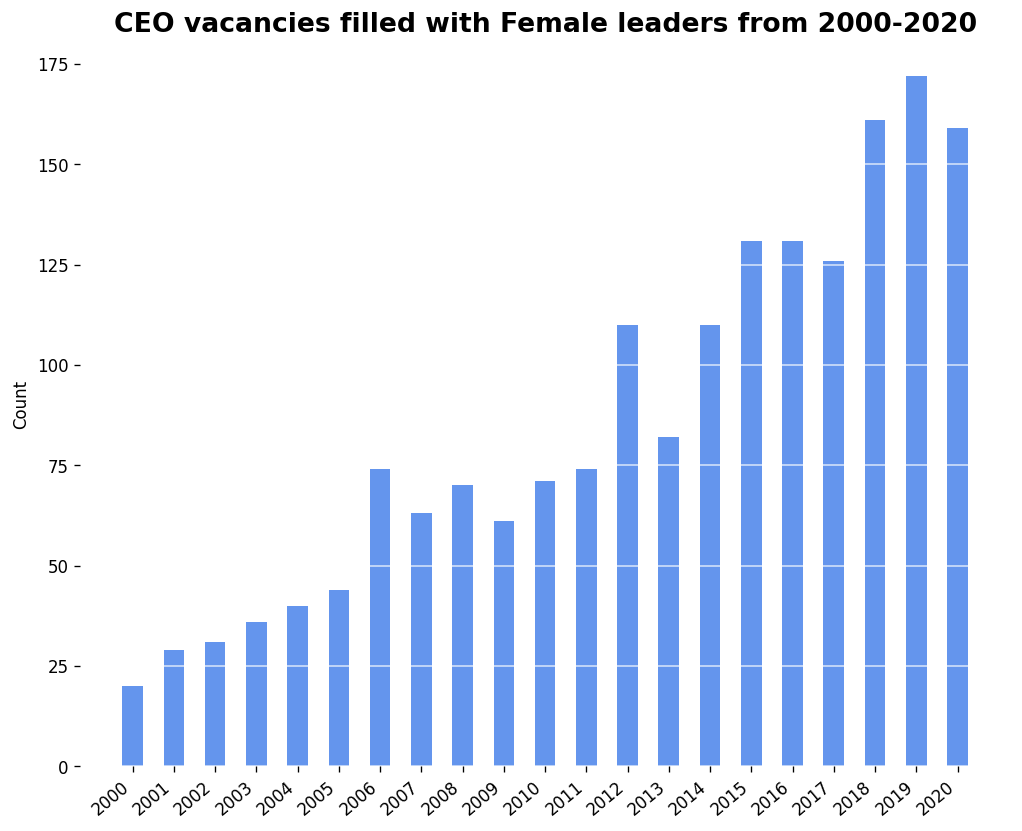

In [563]:
# Plot the change in ceo vacancies filles with female and in percentage across the decades
x = gender_change['Year'].unique()
female = gender_change['Count'].loc[gender_change['Gender']== 1] # female CEO counts
vacancies = gender_change['Year Count'].unique()
percentage = gender_change['Percentage'].loc[gender_change['Gender']==1] # percentage of female CEO

fig= plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.bar(x, female, color='cornflowerblue', width=0.5, label='Female count')

# Subplot settings
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=40, ha='right')
ax.spines[['right','bottom','top', 'left']].set_visible(False)
ax.set_title('CEO vacancies filled with Female leaders from 2000-2020', fontweight='semibold', fontsize=16)
ax.grid(axis='y', linestyle='-', alpha=0.7, color='white', linewidth=1)
ax.set_ylabel('Count')

plt.show()

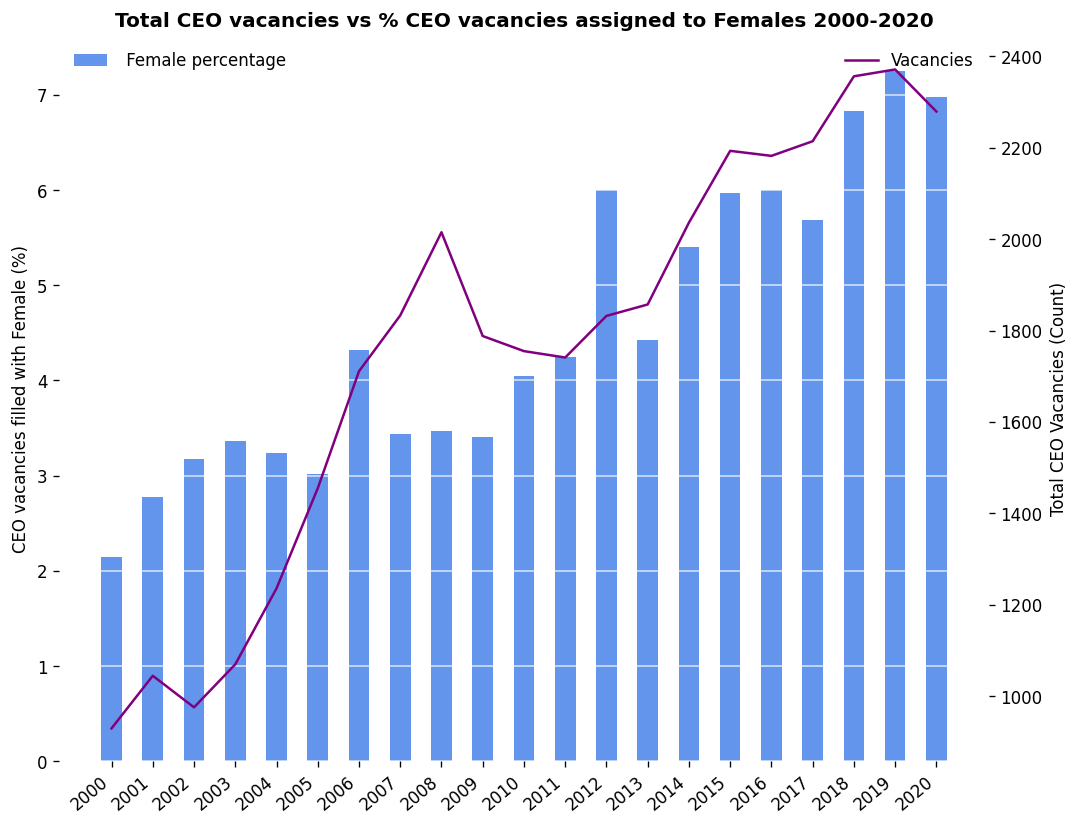

In [564]:
vacancies = gender_change['Year Count'].unique()
percentage = gender_change['Percentage'].loc[gender_change['Gender']==1] # percentage of female CEO

fig= plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.bar(x, percentage, color='cornflowerblue', label=' Female percentage', width=0.5)

# Subplot settings
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=40, ha='right')
ax.spines[['right','bottom','top', 'left']].set_visible(False)
ax.set_title('Total CEO vacancies vs % CEO vacancies assigned to Females 2000-2020', fontweight='semibold')
ax.grid(axis='y', linestyle='-', alpha=0.7, color='white', linewidth=1)
ax.set_ylabel('CEO vacancies filled with Female (%)')
ax.legend(frameon=False)

ax1  = ax.twinx()
ax1.plot(x, vacancies, color= 'Purple', label= 'Vacancies')
ax1.set_ylabel('Total CEO Vacancies (Count)')
ax1.spines[['right','bottom','top', 'left']].set_visible(False)
ax1.legend(loc='upper right', frameon=False)

plt.show()

### Vacancies by country

In [586]:
country_vacan = df_CEO.groupby('Country')['Gender'].value_counts().reset_index(name='Count')
# Get the total number of CEOs in each year
vacan_total = country_vacan.groupby('Country')['Count'].sum().reset_index(name='Total Count')

# Merge the columns together
country_vacan = pd.merge(country_vacan, vacan_total, on='Country', how='left')

# Get the annual percentage of CEO of each gender 
country_vacan['Percentage'] = round(country_vacan['Count'] / country_vacan['Total Count']*100, 2)

# Sort values by country
country_vacan.sort_values(by='Total Count', ascending=False,inplace=True)
country_vacan.reset_index(drop=True, inplace=True)
country_vacan

,Country,Gender,Count,Total Count,Percentage
0,United States,1,829,17685,4.69
1,United States,0,16856,17685,95.31
2,Canada,1,155,3348,4.63
3,Canada,0,3193,3348,95.37
4,United Kingdom - England,1,102,2321,4.39
...,...,...,...,...,...
168,Estonia,0,1,1,100.00
169,French Guiana,0,1,1,100.00
170,Georgia,0,1,1,100.00
171,Jamaica,1,1,1,100.00


In [589]:
country_vacan.loc[country_vacan['Gender'] == 1].head(30)

,Country,Gender,Count,Total Count,Percentage
0,United States,1,829,17685,4.69
2,Canada,1,155,3348,4.63
4,United Kingdom - England,1,102,2321,4.39
7,Australia,1,100,1790,5.59
9,Hong Kong SAR,1,83,1125,7.38
10,France,1,87,1091,7.97
12,Sweden,1,81,922,8.79
15,Germany,1,34,751,4.53
16,India,1,20,614,3.26
19,Brazil,1,17,609,2.79


In [584]:
# 41 Countries without CEO vacancies filled with females
no_female_country = country_vacan['Country']
no_female_country.drop_duplicates(keep=False, inplace=True)
print(no_female_country)

78                                 Chile
101                       Cayman Islands
106                                 Peru
107                            Sri Lanka
108                              Iceland
109                              Hungary
114                            Mauritius
121                                Malta
122                                Egypt
123                          Puerto Rico
124                              Morocco
125                                Qatar
130                             Slovakia
131                              Bahrain
132                           Bangladesh
133                              Bahamas
134                     Papua New Guinea
136                                 Oman
140                  Virgin Islands U.S.
143                        Faroe Islands
146                        Liechtenstein
149                               Monaco
150    United Kingdom - Northern Ireland
151                               Panama
152             

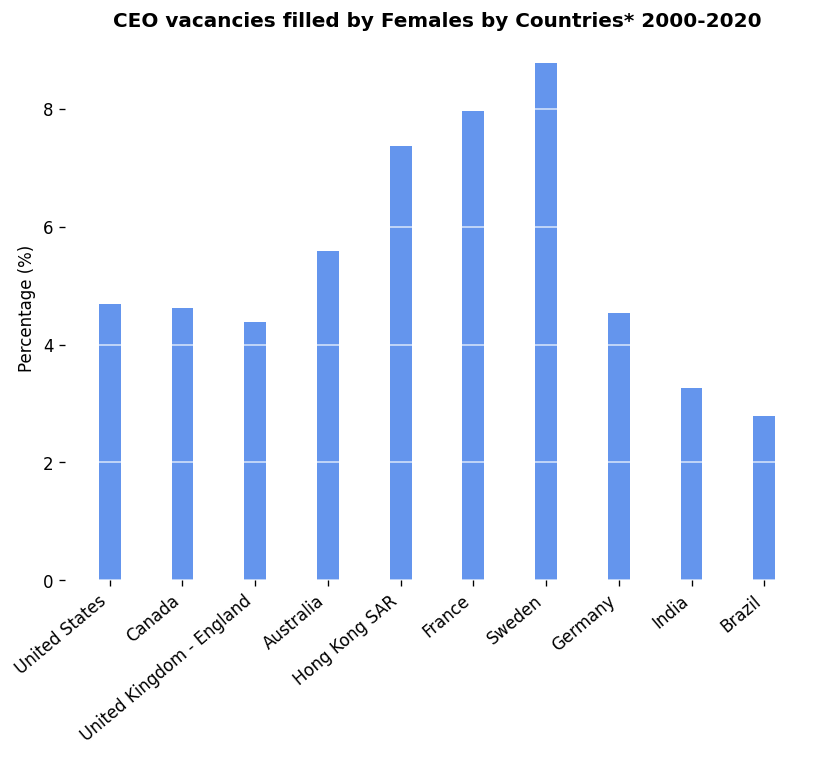

In [559]:
# Plot the % of vacancies filled by women across countries
x = country_vacan['Country'].head(20).unique()
y = country_vacan['Percentage'].loc[country_vacan['Gender'] == 1].head(10)

fig= plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.bar(x, y, color='cornflowerblue', width=0.3, align='center')

# # Subplot settings
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=40, ha='right')
ax.spines[['right','bottom','top', 'left']].set_visible(False)
ax.set_title('CEO vacancies filled by Females by Countries* 2000-2020', fontweight='semibold')
ax.grid(axis='y', linestyle='-', alpha=0.7, color='white', linewidth=1)
ax.set_ylabel('Percentage (%)')
# ax.legend(bbox_to_anchor=(0.145, 0.95), frameon=False)

plt.show()

In [526]:
country_vacan.loc[country_vacan['Gender'] == 1].sort_values(by='Percentage', ascending=False)

,Country,Gender,Count,Total Count,Percentage
171,Jamaica,1,1,1,100.00
156,Togo,1,3,3,100.00
166,Macao SAR,1,1,2,50.00
139,Kenya,1,3,8,37.50
157,Tanzania,1,1,3,33.33
...,...,...,...,...,...
40,Spain,1,4,259,1.54
82,United Arab Emirates,1,1,74,1.35
56,Greece,1,2,150,1.33
28,Japan,1,5,398,1.26


In [555]:
# Analyse the female percentage in each country
female_vacan = country_vacan.loc[(country_vacan['Gender'] == 1) & (country_vacan['Total Count'] > 100)]
female_vacan.sort_values(by='Percentage', ascending=False, inplace=True)
female_vacan.reset_index(drop=True, inplace=True)
female_vacan.head(10)

,Country,Gender,Count,Total Count,Percentage
0,Thailand,1,25,184,13.59
1,Singapore,1,48,455,10.55
2,Sweden,1,81,922,8.79
3,China,1,50,603,8.29
4,France,1,87,1091,7.97
5,Philippines,1,8,102,7.84
6,Hong Kong SAR,1,83,1125,7.38
7,Norway,1,25,349,7.16
8,Russian Federation,1,11,166,6.63
9,New Zealand,1,7,106,6.60


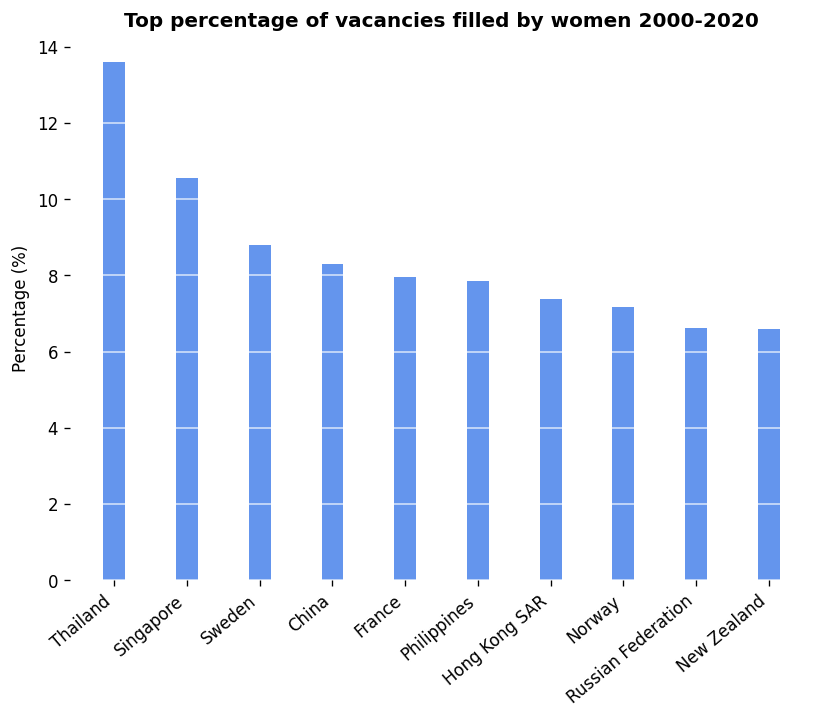

In [560]:
# Plot the change in ceo vacancies filled with female and in percentage by country
x_head = female_vacan['Country'].head(10)
female_head = female_vacan['Percentage'].head(10)

fig= plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.bar(x_head, female_head, color='cornflowerblue', width=0.3)

# # Subplot settings
ax.set_xticks(x_head)
ax.set_xticklabels(x_head, rotation=40, ha='right')
ax.spines[['right','bottom','top', 'left']].set_visible(False)
ax.set_title('Top percentage of vacancies filled by women 2000-2020', fontweight='semibold')
ax.grid(axis='y', linestyle='-', alpha=0.7, color='white', linewidth=1)
ax.set_ylabel('Percentage (%)')
# ax.legend(bbox_to_anchor=(0.145, 0.95), frameon=False)

plt.show()

### Vacancies by sector

In [96]:
# See the vacancies by sector
sector_vacan = df_CEO.groupby('Sector Name')['Gender'].value_counts().reset_index(name='Count')

# Get the total number of CEO vacancies in each year
sector_total = sector_vacan.groupby('Sector Name')['Count'].sum().reset_index(name='Total Count')

# Merge the columns together
sector_vacan = pd.merge(sector_vacan, sector_total, on='Sector Name', how='left')

# Get the annual percentage of CEO vacancies filled by each gender 
sector_vacan['Percentage'] = round(sector_vacan['Count'] / sector_vacan['Total Count']*100, 2)

# Sort values by total count
sector_vacan.sort_values(by='Total Count', ascending=False,inplace=True)
sector_vacan.reset_index(drop=True, inplace=True)
sector_vacan

,Sector Name,Gender,Count,Total Count,Percentage
0,Pharmaceuticals and Biotechnology,0,2564,2731,93.89
1,Pharmaceuticals and Biotechnology,1,167,2731,6.11
2,Software & Computer Services,1,96,2524,3.80
3,Software & Computer Services,0,2428,2524,96.20
4,Mining,0,2369,2460,96.30
...,...,...,...,...,...
84,Blank Check / Shell Companies,1,1,30,3.33
85,Blank Check / Shell Companies,0,29,30,96.67
86,Wholesale Trade,0,7,8,87.50
87,Wholesale Trade,1,1,8,12.50


In [106]:
# Sectors without CEO vacancies filled with females
no_female_sector = sector_vacan['Sector Name']
no_female_sector.drop_duplicates(keep=False, inplace=True)
no_female_sector

88    Legal
Name: Sector Name, dtype: object

In [567]:
# Analyse the vacancies filled by women in each sector
female_vacan = sector_vacan.loc[sector_vacan['Gender'] == 1]
female_vacan.sort_values(by='Percentage', ascending=False, inplace=True)
female_vacan.reset_index(drop=True, inplace=True)
female_vacan.tail(10)

,Sector Name,Gender,Count,Total Count,Percentage
34,Blank Check / Shell Companies,1,1,30,3.33
35,Electronic & Electrical Equipment,1,60,2012,2.98
36,Oil & Gas,1,68,2323,2.93
37,Forestry & Paper,1,8,274,2.92
38,Information Technology Hardware,1,28,1001,2.80
39,Automobiles & Parts,1,13,482,2.70
40,Renewable Energy,1,14,552,2.54
41,Containers & Packaging,1,3,143,2.10
42,Life Assurance,1,2,96,2.08
43,Construction & Building Materials,1,22,1090,2.02


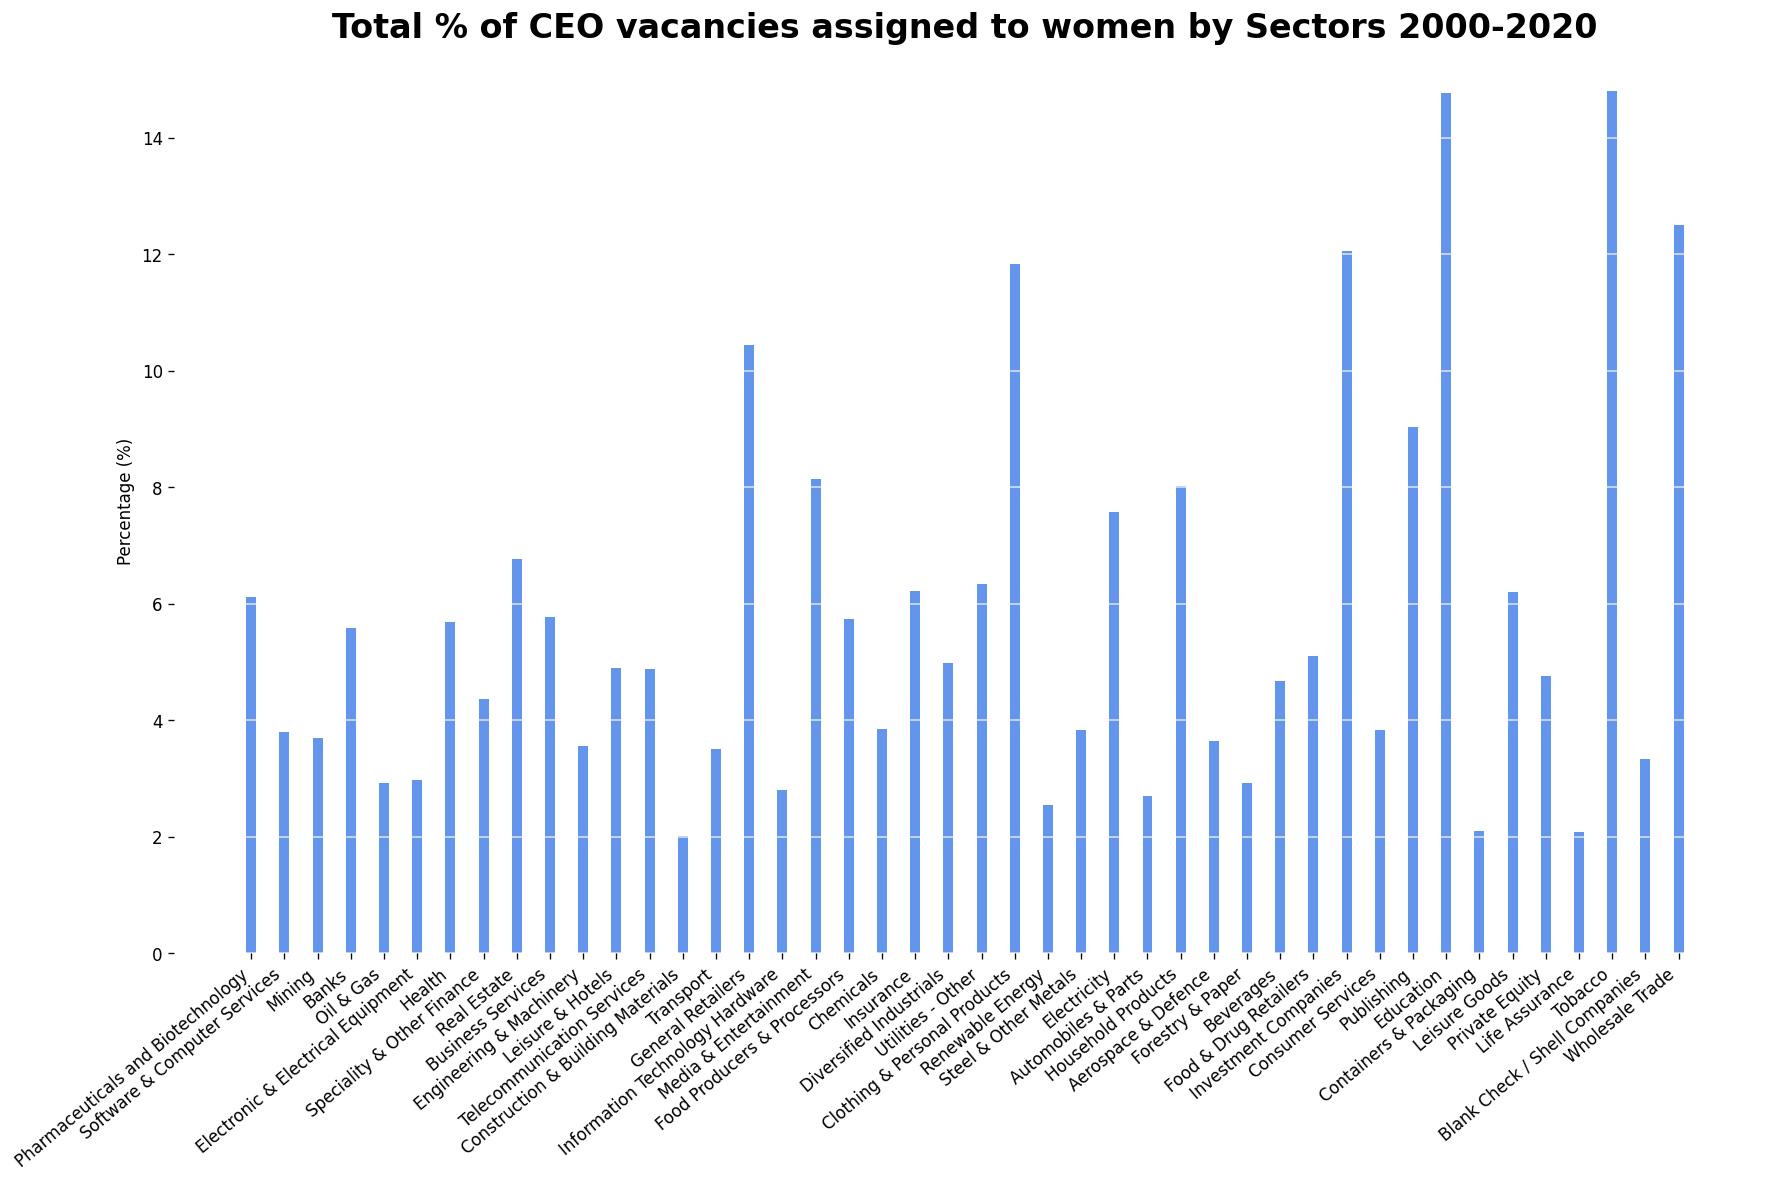

In [570]:
# Plot the ceo vacancies filled with female and in percentage across sectors
x = sector_vacan['Sector Name'].loc[sector_vacan['Gender'] == 1]
y = sector_vacan['Percentage'].loc[sector_vacan['Gender'] == 1]

fig= plt.figure(figsize=(17,10))
ax = fig.add_subplot()
ax.bar(x, y, color='cornflowerblue', width=0.3, align='center')

# # Subplot settings
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=40, ha='right')
ax.spines[['right','bottom','top', 'left']].set_visible(False)
ax.set_title('Total % of CEO vacancies assigned to women by Sectors 2000-2020', fontweight='semibold', fontsize=20)
ax.grid(axis='y', linestyle='-', alpha=0.7, color='white', linewidth=1)
ax.set_ylabel('Percentage (%)')

plt.show()

### Male-Female differences

In [21]:
# Decriptive statistics of the dataframe
df_CEO.describe()

,CompanyID*,company_index,ex_ceo_gender,DirectorID*,Gender,Bachelor,Doctorate,MBA,Master,Other,Experience,Same_role,Same_company,Same_sector,Year
count,3.864200e+04,38642.000000,38642.000000,3.864200e+04,38642.000000,38642.000000,38642.000000,38642.000000,38642.000000,38642.000000,38642.000000,38642.000000,38642.000000,38642.000000,38642.000000
mean,3.357151e+10,0.288986,0.038016,2.775480e+10,0.049972,0.855080,0.080249,0.314269,0.226256,0.368614,12.480030,0.467704,0.687749,0.782930,2011.921070
std,6.657412e+10,0.453297,0.191236,4.784935e+10,0.217889,0.352025,0.271683,0.464230,0.418412,0.482435,10.559209,0.498962,0.463418,0.412256,5.952821
min,1.170000e+03,0.000000,0.000000,8.539000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2000.000000
25%,3.234085e+08,0.000000,0.000000,4.742118e+09,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.410000,0.000000,0.000000,1.000000,2007.000000
50%,3.730662e+09,0.000000,0.000000,1.122724e+10,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,10.400000,0.000000,1.000000,1.000000,2012.000000
75%,2.105604e+10,1.000000,0.000000,2.178532e+10,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,19.350000,1.000000,1.000000,1.000000,2017.000000
max,3.086372e+11,1.000000,1.000000,2.070682e+11,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,59.120000,1.000000,1.000000,1.000000,2021.000000


In [22]:
# Descriptive statistics for Female managers
female = df_CEO.loc[df_CEO['Gender'] == 1]
female.describe()

,CompanyID*,company_index,ex_ceo_gender,DirectorID*,Gender,Bachelor,Doctorate,MBA,Master,Other,Experience,Same_role,Same_company,Same_sector,Year
count,1.931000e+03,1931.000000,1931.000000,1.931000e+03,1931.0,1931.000000,1931.000000,1931.000000,1931.000000,1931.000000,1931.000000,1931.000000,1931.000000,1931.000000,1931.000000
mean,4.100784e+10,0.287934,0.343863,3.709671e+10,1.0,0.850854,0.079751,0.305023,0.259969,0.382703,11.944666,0.432936,0.678923,0.784050,2013.686173
std,7.486624e+10,0.452917,0.475119,5.694812e+10,0.0,0.356324,0.270978,0.460537,0.438731,0.486173,10.011171,0.495610,0.467011,0.411587,5.587728
min,3.570000e+03,0.000000,0.000000,3.108686e+07,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2000.000000
25%,3.403948e+08,0.000000,0.000000,5.788411e+09,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,3.185000,0.000000,0.000000,1.000000,2010.000000
50%,5.880349e+09,0.000000,0.000000,1.362428e+10,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,10.080000,0.000000,1.000000,1.000000,2015.000000
75%,2.412450e+10,1.000000,1.000000,2.569369e+10,1.0,1.000000,0.000000,1.000000,1.000000,1.000000,18.560000,1.000000,1.000000,1.000000,2018.000000
max,3.079117e+11,1.000000,1.000000,2.069160e+11,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,52.600000,1.000000,1.000000,1.000000,2021.000000


In [23]:
# Descriptive Statistics for Male managers
male = df_CEO.loc[df_CEO['Gender'] == 0]
male.describe()

,CompanyID*,company_index,ex_ceo_gender,DirectorID*,Gender,Bachelor,Doctorate,MBA,Master,Other,Experience,Same_role,Same_company,Same_sector,Year
count,3.671100e+04,36711.000000,36711.000000,3.671100e+04,36711.0,36711.000000,36711.000000,36711.000000,36711.000000,36711.000000,36711.000000,36711.000000,36711.000000,36711.000000,36711.000000
mean,3.318036e+10,0.289041,0.021928,2.726342e+10,0.0,0.855302,0.080276,0.314756,0.224483,0.367873,12.508190,0.469532,0.688213,0.782872,2011.828226
std,6.608714e+10,0.453323,0.146451,4.727219e+10,0.0,0.351801,0.271723,0.464425,0.417247,0.482233,10.586631,0.499078,0.463230,0.412296,5.957017
min,1.170000e+03,0.000000,0.000000,8.539000e+04,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2000.000000
25%,3.226584e+08,0.000000,0.000000,4.655211e+09,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,3.420000,0.000000,0.000000,1.000000,2007.000000
50%,3.713812e+09,0.000000,0.000000,1.109750e+10,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,10.420000,0.000000,1.000000,1.000000,2012.000000
75%,2.087427e+10,1.000000,0.000000,2.111613e+10,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,19.425000,1.000000,1.000000,1.000000,2017.000000
max,3.086372e+11,1.000000,1.000000,2.070682e+11,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,59.120000,1.000000,1.000000,1.000000,2021.000000


### t-test for statistical difference

In [18]:
import scipy.stats as stats

In [24]:
# Perform the t-test between gender= Female/ Male with the rest of columns
columns = ['Bachelor', 'Doctorate', 'MBA', 'Master', 'Other', 'Experience', 'Same_role',
       'Same_company', 'Same_sector', 'ex_ceo_gender', 'company_index']
for i in columns:
    result= stats.ttest_ind(df_CEO[i][df_CEO['Gender'] == 0], # male
                df_CEO[i][df_CEO['Gender'] == 1]) # female
    print('t-test of ',i,':' ,result)

t-test of  Bachelor : Ttest_indResult(statistic=0.5411557090675999, pvalue=0.5884033824287416)
t-test of  Doctorate : Ttest_indResult(statistic=0.08264648997037082, pvalue=0.9341330621368011)
t-test of  MBA : Ttest_indResult(statistic=0.8979433331605514, pvalue=0.3692213558372618)
t-test of  Master : Ttest_indResult(statistic=-3.6331057184272972, pvalue=0.0002803927533111487)
t-test of  Other : Ttest_indResult(statistic=-1.3166243532454978, pvalue=0.1879723805193076)
t-test of  Experience : Ttest_indResult(statistic=2.285937720858215, pvalue=0.022263289857603032)
t-test of  Same_role : Ttest_indResult(statistic=3.1417748447793388, pvalue=0.001680538716627663)
t-test of  Same_company : Ttest_indResult(statistic=0.8586669748652281, pvalue=0.3905296021914463)
t-test of  Same_sector : Ttest_indResult(statistic=-0.12239623867652133, pvalue=0.9025858537404801)
t-test of  ex_ceo_gender : Ttest_indResult(statistic=-77.50492078386941, pvalue=0.0)
t-test of  company_index : Ttest_indResult(stati

### Histogram and Correlation Matrix

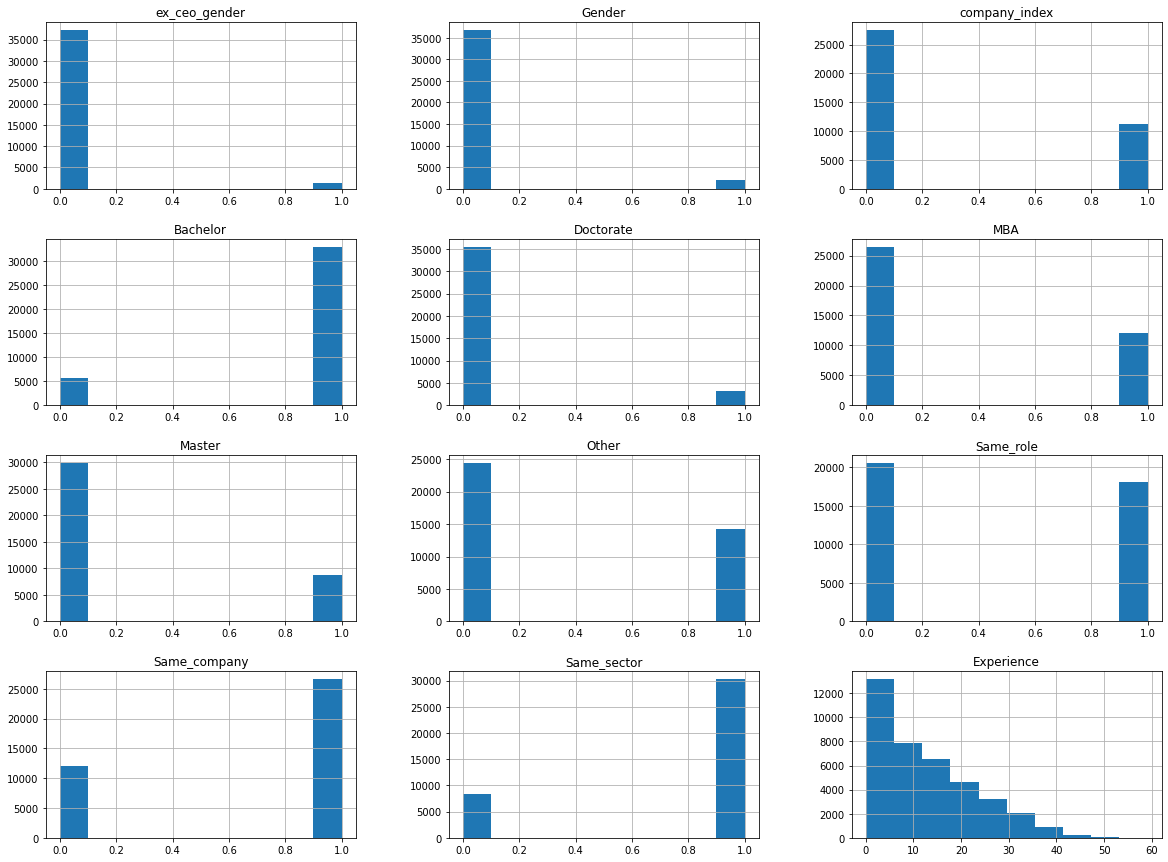

In [26]:
# visualize the distribution of the features that will be used in the logistic regression
columns = ['ex_ceo_gender', 'Gender', 'company_index','Bachelor', 'Doctorate', 'MBA', 'Master', 'Other', 'Same_role', 'Same_company', 'Same_sector', 'Experience']
df_CEO[columns].hist(bins=10, figsize=(20,15))
plt.show()

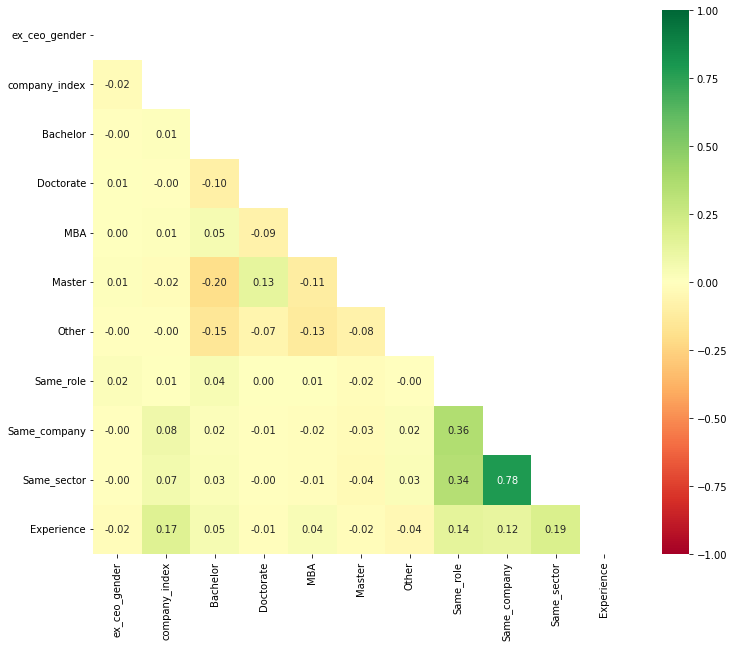

In [27]:
# plot correlation matrix of the independent variables
variables = ['ex_ceo_gender', 'company_index','Bachelor', 'Doctorate', 'MBA', 'Master', 'Other', 'Same_role', 'Same_company', 'Same_sector', 'Experience']
fig = plt.figure(figsize=(12,10))
sns.heatmap(df_CEO[variables].corr(), mask=np.triu(np.ones_like(df_CEO[variables].corr(), dtype=bool)), 
            annot=True, fmt='.2f', cmap='RdYlGn', vmin=-1, vmax=1)
plt.show()

## 2.3. Logistic Regression

### Model 1: Base model

In [28]:
# Base model: with all the variables in the dataframe
model1 = smf.logit("Gender ~ ex_ceo_gender + company_index +Bachelor + Doctorate + MBA + Master + Other + Experience+ Same_role+Same_company+Same_sector", data=df_CEO).fit()
print(model1.summary())

Optimization terminated successfully.
         Current function value: 0.168574
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Gender   No. Observations:                38642
Model:                          Logit   Df Residuals:                    38630
Method:                           MLE   Df Model:                           11
Date:                Sat, 27 Aug 2022   Pseudo R-squ.:                  0.1505
Time:                        14:45:33   Log-Likelihood:                -6514.1
converged:                       True   LL-Null:                       -7667.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.4503      0.097    -35.405      0.000      -3.641      -3.259
ex_ceo_gender     3.

### Model 2: Improved Model 1

In [29]:
# Model 2: just including the variables that are significant
model2 = smf.logit("Gender ~ ex_ceo_gender + Master + Same_role + Same_sector", data=df_CEO).fit()
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.168700
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Gender   No. Observations:                38642
Model:                          Logit   Df Residuals:                    38637
Method:                           MLE   Df Model:                            4
Date:                Sat, 27 Aug 2022   Pseudo R-squ.:                  0.1498
Time:                        14:47:39   Log-Likelihood:                -6518.9
converged:                       True   LL-Null:                       -7667.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.3827      0.059    -57.425      0.000      -3.498      -3.267
ex_ceo_gender     3.

### Model 3: Adding new variable

In [30]:
# Create a new column to the df_CEO with the interaction between same_sector and same_company
df_CEO['Same_comp_sector'] = 0

# For individuals that worked in different company and sector = 0
nothing = (df_CEO['Same_company']==0) & (df_CEO['Same_sector']==0)
nothing_index = df_CEO[nothing].index
df_CEO.loc[nothing_index, 'Same_comp_sector'] = 0
# For individuals that worked the same company and same sector = 1
same = (df_CEO['Same_company']==1) & (df_CEO['Same_sector']==1)
same_index = df_CEO[same].index
df_CEO.loc[same_index, 'Same_comp_sector'] = 1

# For individuals that worked in different company but same sector = 2
sector = (df_CEO['Same_company']==0) & (df_CEO['Same_sector']==1)
sector_index = df_CEO[sector].index
df_CEO.loc[sector_index, 'Same_comp_sector'] = 2


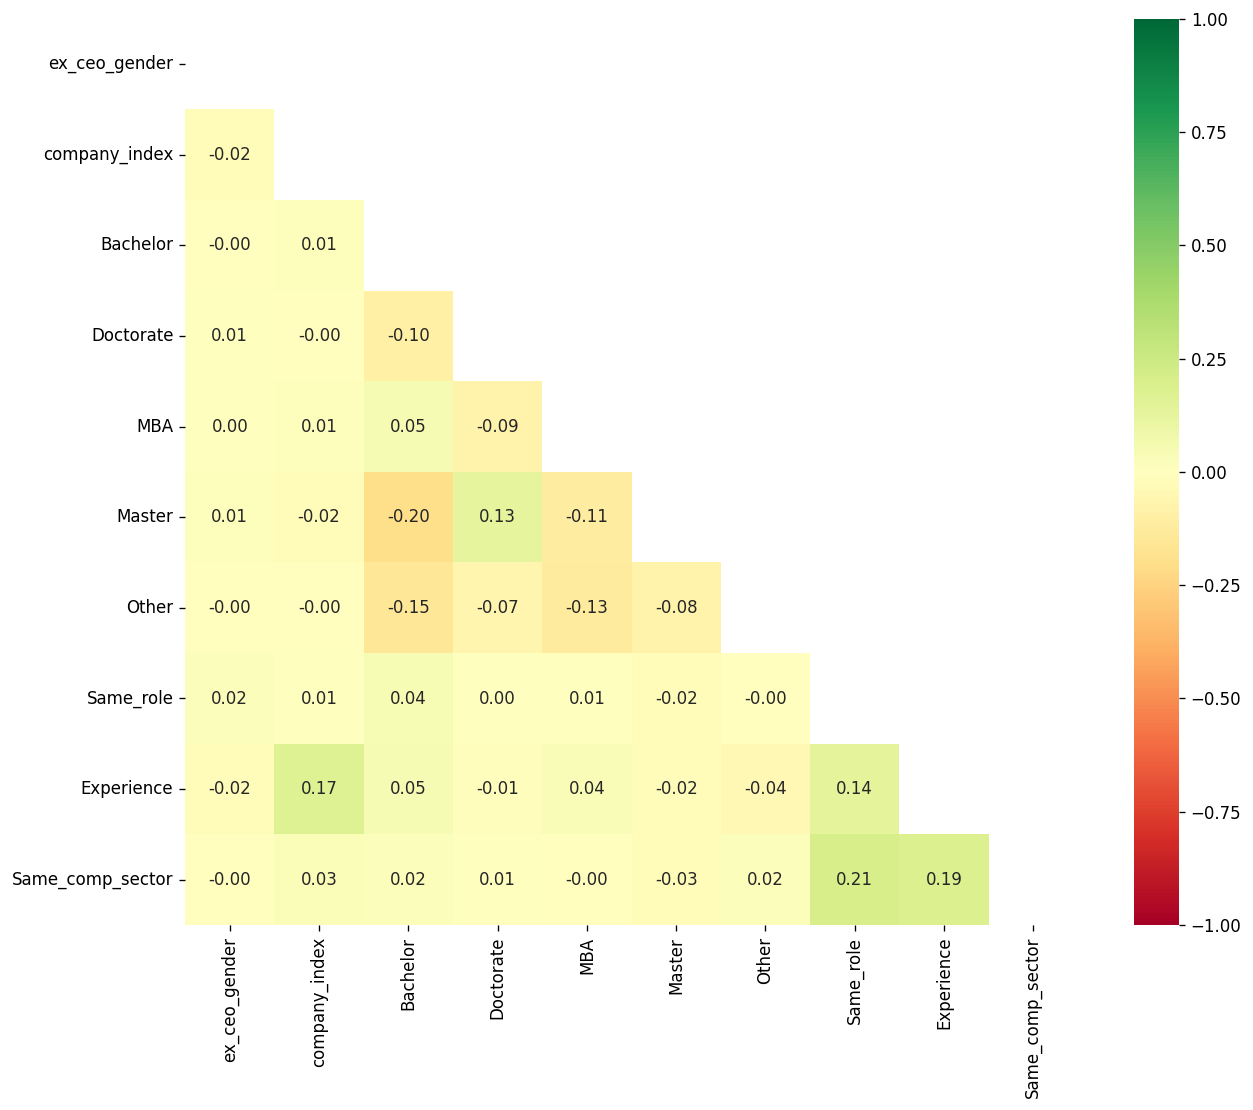

In [572]:
# Check correlation of the new variable with the rest of the variables
new = ['ex_ceo_gender', 'company_index','Bachelor', 'Doctorate', 'MBA', 'Master', 'Other', 'Same_role', 'Experience', 'Same_comp_sector']
fig = plt.figure(figsize=(12,10))
sns.heatmap(df_CEO[new].corr(), mask=np.triu(np.ones_like(df_CEO[new].corr(), dtype=bool)), 
            annot=True, fmt='.2f', cmap='RdYlGn', vmin=-1, vmax=1)
plt.show()

In [573]:
# Model 3: using the new variable instead of same_company and same_sector
model3 = smf.logit("Gender ~ ex_ceo_gender +company_index+ Bachelor + Doctorate + MBA + Master + Other + Experience+ Same_role+C(Same_comp_sector)", data=df_CEO).fit()
print(model3.summary())

Optimization terminated successfully.
         Current function value: 0.168574
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Gender   No. Observations:                38642
Model:                          Logit   Df Residuals:                    38630
Method:                           MLE   Df Model:                           11
Date:                Tue, 30 Aug 2022   Pseudo R-squ.:                  0.1505
Time:                        11:47:56   Log-Likelihood:                -6514.1
converged:                       True   LL-Null:                       -7667.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -3.4503      0.097    -35.405      0.000      -3.641

### Model 4: Improved Model 3

In [33]:
# Model 4: with the significant variables from Model 3
model4 = smf.logit("Gender ~ ex_ceo_gender + Master + Same_role+ C(Same_comp_sector)", data=df_CEO).fit()
print(model4.summary())

Optimization terminated successfully.
         Current function value: 0.168696
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Gender   No. Observations:                38642
Model:                          Logit   Df Residuals:                    38636
Method:                           MLE   Df Model:                            5
Date:                Sat, 27 Aug 2022   Pseudo R-squ.:                  0.1499
Time:                        14:48:55   Log-Likelihood:                -6518.8
converged:                       True   LL-Null:                       -7667.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -3.3831      0.059    -57.427      0.000      -3.499

### Model Evaluation and Selection

In [34]:
# Get the AIC score of each model for comparison
print("AIC of Model 1: ", model1.aic)
print("AIC of Model 2: ", model2.aic)
print("AIC of Model 3: ", model3.aic)
print("AIC of Model 4: ", model4.aic)

AIC of Model 1:  13052.103143727123
AIC of Model 2:  13047.777559926166
AIC of Model 3:  13053.633605990573
AIC of Model 4:  13049.51456475632


### Odds ratio

In [169]:
# Get the parameters estimated from the model
parameters = model2.params
# Convert it into dictionary
parameters.to_dict()
# Get the confidence interval values of the parameters
conf_int = model2.conf_int(0.05)
# Convert the parameter dictionary into dataframe
odds_ratio = pd.DataFrame(parameters)
# Merge the two dataframe together
odds_ratio = pd.merge(odds_ratio, conf_int, on=odds_ratio.index)
# Drop the intercept row
odds_ratio.drop([0], inplace=True)
# Change the name of the columns
odds_ratio.columns=['Variable', 'Coefficient', 'Lower_bound', 'Upper_bound']
# Compute the odds ratio for the coefficients and the intervals
odds_ratio['Odds'] = odds_ratio['Coefficient'].apply(lambda x: np.exp(x))
odds_ratio['Odds_lower'] = odds_ratio['Lower_bound'].apply(lambda x: np.exp(x))
odds_ratio['Odds_upper'] = odds_ratio['Upper_bound'].apply(lambda x: np.exp(x))
odds_ratio

,Variable,Coefficient,Lower_bound,Upper_bound,Odds,Odds_lower,Odds_upper
1,ex_ceo_gender,3.173093,3.055249,3.290937,23.881232,21.226460,26.868034
2,Master,0.176622,0.063432,0.289812,1.193180,1.065487,1.336176
3,Same_role,-0.284653,-0.390409,-0.178897,0.752275,0.676780,0.836192
4,Same_sector,0.153319,0.026015,0.280623,1.165697,1.026356,1.323955
